# Installs & Imports

In [1]:
!pip install -q yfinance ta torch torchvision optuna lion-pytorch pykalman

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import ta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset

from pykalman import KalmanFilter

import os
import random
import json
import math
import copy

import warnings
warnings.filterwarnings('ignore')

# Set plot styles
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# Show all columns
pd.set_option('display.max_columns', None)

# Enable synchronous error reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
def set_seed(seed=42):
    """
    Sets random seeds for reproducibility.

    Args:
        seed (int): The seed value to set.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# Load the Data

In [4]:
def fetch_data(ticker='^GSPC', start='2000-01-01', end='2024-10-22'):
    """
    Fetch historical data for the specified ticker.

    Args:
        ticker (str): Stock ticker symbol.
        start (str): Start date in 'YYYY-MM-DD' format.
        end (str): End date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame containing the 'Close' prices with a clean index.
    """
    # Download data using yfinance
    data = yf.download(ticker, start=start, end=end)

    # Select only the 'Close' column
    data = data[['Close']].copy()

    # Check if columns have a MultiIndex and flatten them if necessary
    if isinstance(data.columns, pd.MultiIndex):
        # Combine multi-index levels into single level
        data.columns = ['_'.join(col).strip() for col in data.columns.values]

    # Remove the time component from the Date index by converting to datetime.date
    data.index = pd.to_datetime(data.index).date

    # Rename the index to 'Date' for clarity
    data.index.name = 'Date'

    # Rename the column to 'Close'
    data.columns = ['Close']

    return data

In [5]:
# Load the data
data = fetch_data()
print("\n\nFirst five rows of the data:")
display(data.head(10))
print("\nLast five rows of the data:")
display(data.tail(10))

[*********************100%***********************]  1 of 1 completed



First five rows of the data:


,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
2000-01-10,1457.599976
2000-01-11,1438.560059
2000-01-12,1432.250000
2000-01-13,1449.680054



Last five rows of the data:


,Close
Date,
2024-10-08,5751.129883
2024-10-09,5792.040039
2024-10-10,5780.049805
2024-10-11,5815.029785
2024-10-14,5859.850098
2024-10-15,5815.259766
2024-10-16,5842.470215
2024-10-17,5841.470215
2024-10-18,5864.669922


# Explore the Data

In [6]:
def descriptive_statistics(data):
    """
    Display descriptive statistics of the data.

    Args:
        data (pd.DataFrame): DataFrame containing the data.
    """
    desc_stats = data.describe()
    print("Descriptive Statistics:")
    display(desc_stats)

descriptive_statistics(data)

Descriptive Statistics:


,Close
count,6240.000000
mean,2081.921106
std,1200.680324
min,676.530029
25%,1198.780029
50%,1481.549988
75%,2727.030029
max,5864.669922


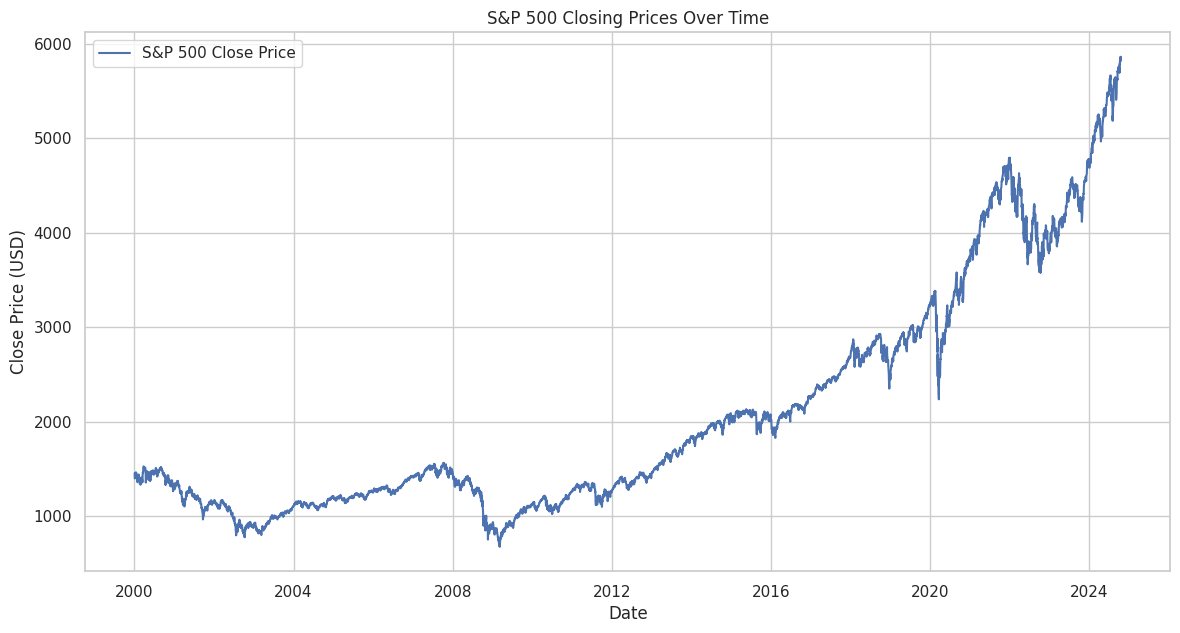

In [7]:
def plot_closing_prices(data):
    """
    Plot the closing prices over time.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
    """
    plt.figure(figsize=(14,7))
    plt.plot(data.index, data['Close'], label='S&P 500 Close Price')
    plt.title('S&P 500 Closing Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.show()

plot_closing_prices(data)

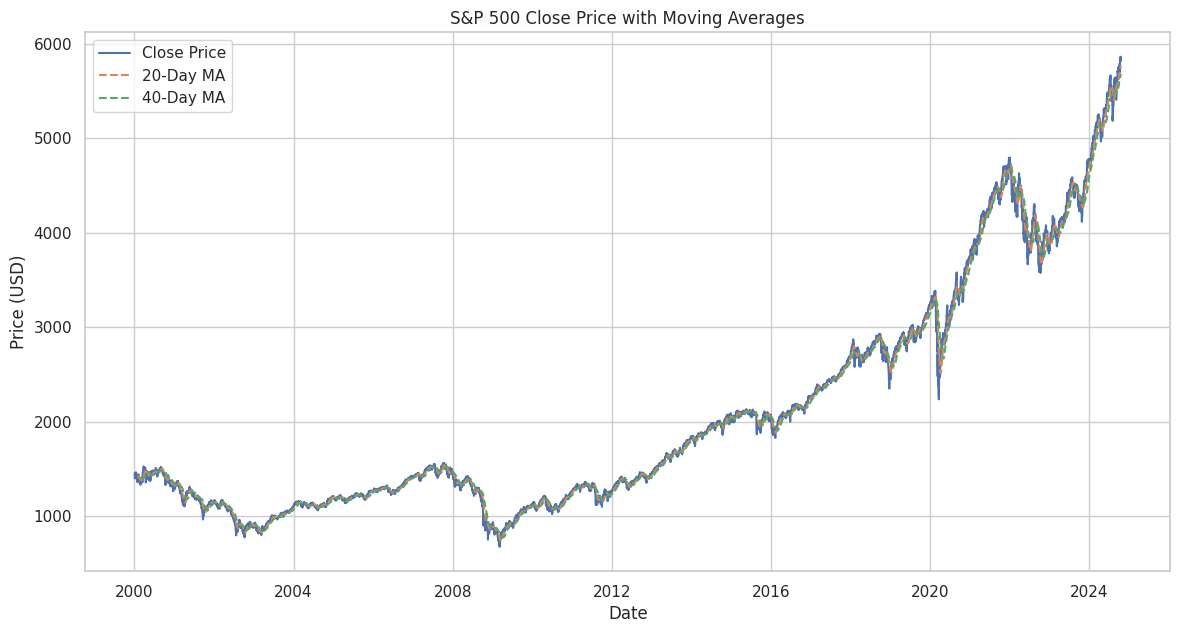

In [8]:
def plot_moving_averages(data, windows=[20, 40]):
    """
    Plot closing prices along with specified moving averages.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
        windows (list): List of window sizes for moving averages.
    """
    data_copy = data.copy()
    for window in windows:
        data_copy[f'{window}_MA'] = data_copy['Close'].rolling(window=window).mean()

    plt.figure(figsize=(14,7))
    plt.plot(data_copy.index, data_copy['Close'], label='Close Price')
    for window in windows:
        plt.plot(data_copy.index, data_copy[f'{window}_MA'], label=f'{window}-Day MA', linestyle='--')
    plt.title('S&P 500 Close Price with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

plot_moving_averages(data)

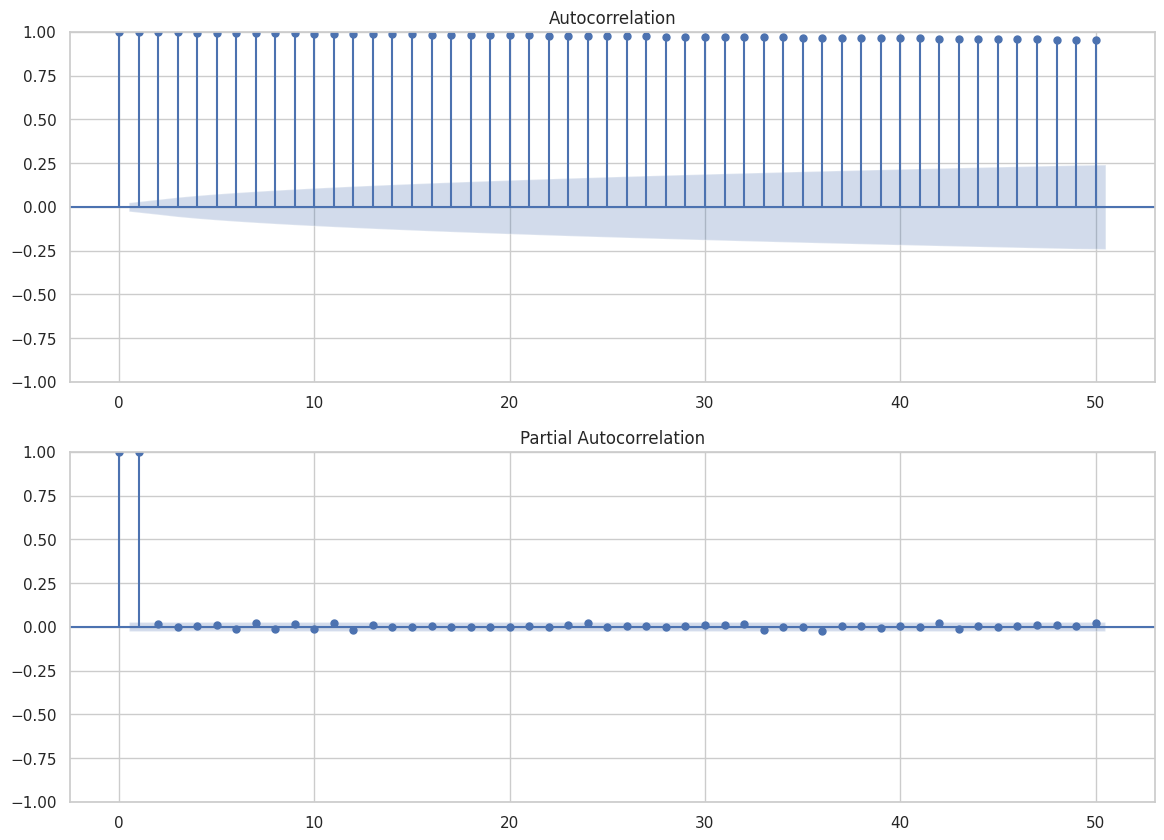


ADF Statistic: 2.629556
p-value: 0.999080
The time series is non-stationary.


In [9]:
def check_autocorrelation_and_stationarity(data):
    """
    Plot ACF and PACF and perform the Augmented Dickey-Fuller test.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
    """
    # Plot ACF and PACF
    fig, ax = plt.subplots(2,1, figsize=(14,10))
    plot_acf(data['Close'].dropna(), ax=ax[0], lags=50)
    plot_pacf(data['Close'].dropna(), ax=ax[1], lags=50)
    plt.show()

    # Augmented Dickey-Fuller test for stationarity
    adf_result = adfuller(data['Close'].dropna())
    print('\nADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])

    if adf_result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")

check_autocorrelation_and_stationarity(data)

In [10]:
def add_moving_average(data, window=20):
    """
    Add a moving average feature to the data.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
        window (int): Window size for moving average.

    Returns:
        pd.DataFrame: DataFrame with the new moving average column.
    """
    data[f'{window}_MA'] = data['Close'].rolling(window=window).mean()
    data = data.dropna()
    return data

In [11]:
# Add moving averages
data_copy = data.copy()
data_copy = add_moving_average(data_copy, window=20)
data_copy = add_moving_average(data_copy, window=40)
print("Data after adding 20-Day and 40-Day Moving Averages:")
display(data_copy.head(10))

Data after adding 20-Day and 40-Day Moving Averages:


,Close,20_MA,40_MA
Date,,,
2000-03-27,1523.859985,1426.727991,1408.502243
2000-03-28,1507.729980,1433.793488,1411.333994
2000-03-29,1508.520020,1440.259991,1413.814993
2000-03-30,1487.920044,1445.567993,1415.784995
2000-03-31,1498.579956,1450.038489,1417.625244
2000-04-03,1505.969971,1455.772986,1419.665244
2000-04-04,1494.729980,1462.728485,1421.427493
2000-04-05,1487.369995,1468.761987,1422.568744
2000-04-06,1501.339966,1473.744489,1424.809494


In [12]:
def add_technical_indicators(data):
    """
    Add technical indicators to the data.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.

    Returns:
        pd.DataFrame: DataFrame with the new technical indicators.
    """
    # Exponential Moving Average (EMA)
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()

    # Relative Strength Index (RSI)
    data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

    # Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_diff'] = macd.macd_diff()

    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'], window=20)
    data['BB_high'] = bollinger.bollinger_hband()
    data['BB_low'] = bollinger.bollinger_lband()

    # Drop rows with NaN values
    data = data.dropna()

    return data

In [13]:
# Add other technical indicators
data_copy = add_technical_indicators(data_copy)
print("Data after adding technical indicators:")
display(data_copy.head(10))

Data after adding technical indicators:


,Close,20_MA,40_MA,EMA_20,RSI,MACD,MACD_diff,BB_high,BB_low
Date,,,,,,,,,
2000-05-12,1420.959961,1428.361505,1462.068747,1434.555079,45.141792,-18.999853,-1.486231,1486.252439,1370.470571
2000-05-15,1452.359985,1433.151501,1461.765997,1436.250784,51.691062,-15.271166,1.793965,1481.563069,1384.739934
2000-05-16,1466.040039,1436.381506,1462.001248,1439.087856,54.253490,-11.084513,4.784494,1484.518339,1388.244674
2000-05-17,1447.800049,1436.691010,1460.849500,1439.917589,50.413808,-9.133095,5.388730,1485.037475,1388.344544
2000-05-18,1437.209961,1437.178009,1459.263748,1439.659719,48.277462,-8.344919,4.941525,1485.338993,1389.017025
2000-05-19,1406.949951,1435.798505,1456.253748,1436.544503,42.708314,-10.046207,2.592190,1485.730695,1385.866315
2000-05-22,1400.719971,1434.341504,1453.085248,1433.132643,41.643213,-11.761616,0.701424,1486.531347,1382.151661
2000-05-23,1373.859985,1429.162506,1449.335248,1427.487628,37.321631,-15.114240,-2.120960,1483.720726,1374.604286
2000-05-24,1399.050049,1426.065509,1446.618250,1424.779287,43.267789,-15.559233,-2.052762,1480.074657,1372.056361


In [14]:
def add_lagged_features(data, lags=[1, 2, 3, 4, 5, 10, 15, 20]):
    """
    Add lagged features to the data.

    Args:
        data (pd.DataFrame): DataFrame containing the 'Close' prices.
        lags (list): List of lag periods to add.

    Returns:
        pd.DataFrame: DataFrame with new lagged feature columns.
    """
    for lag in lags:
        data[f'Close_lag_{lag}'] = data['Close'].shift(lag)
    data = data.dropna()
    return data

In [15]:
# Add lagged features
data_copy = add_lagged_features(data_copy, lags=[1, 2, 3, 4, 5, 10, 15, 20])
print("Data after adding lagged features:")
display(data_copy.head(10))

Data after adding lagged features:


,Close,20_MA,40_MA,EMA_20,RSI,MACD,MACD_diff,BB_high,BB_low,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_10,Close_lag_15,Close_lag_20
Date,,,,,,,,,,,,,,,,,
2000-06-12,1446.000000,1433.704999,1431.033252,1440.919817,51.307063,5.915557,5.438869,1498.610010,1368.799988,1456.949951,1461.670044,1471.359985,1457.839966,1467.630005,1378.020020,1406.949951,1420.959961
2000-06-13,1469.439941,1434.558997,1433.855249,1443.636019,56.202480,7.321432,5.475795,1500.857856,1368.260138,1446.000000,1456.949951,1461.670044,1471.359985,1457.839966,1422.449951,1400.719971,1452.359985
2000-06-14,1470.540039,1434.783997,1435.582751,1446.198307,56.423907,8.427223,5.265269,1501.537664,1368.030329,1469.439941,1446.000000,1456.949951,1461.670044,1471.359985,1420.599976,1373.859985,1466.040039
2000-06-15,1478.729980,1436.330493,1436.510751,1449.296562,58.121401,9.850875,5.351137,1505.604239,1367.056747,1470.540039,1469.439941,1446.000000,1456.949951,1461.670044,1448.810059,1399.050049,1447.800049
2000-06-16,1464.459961,1437.692993,1437.435501,1450.740695,54.162394,9.715662,4.172740,1508.045853,1367.340133,1478.729980,1470.540039,1469.439941,1446.000000,1456.949951,1477.260010,1381.520020,1437.209961
2000-06-19,1486.000000,1441.645496,1438.722000,1454.098724,58.731919,11.217300,4.539502,1513.511498,1369.779493,1464.459961,1478.729980,1470.540039,1469.439941,1446.000000,1467.630005,1378.020020,1406.949951
2000-06-20,1475.949951,1445.406995,1439.874249,1456.179793,55.930340,11.464252,3.829163,1516.177795,1374.636194,1486.000000,1464.459961,1478.729980,1470.540039,1469.439941,1457.839966,1422.449951,1400.719971
2000-06-21,1479.130005,1450.670496,1439.916501,1458.365528,56.635222,11.780765,3.316541,1514.712215,1386.628776,1475.949951,1486.000000,1464.459961,1478.729980,1470.540039,1471.359985,1420.599976,1373.859985
2000-06-22,1452.180054,1453.326996,1439.696252,1457.776435,49.420893,9.744638,1.024331,1512.830235,1393.823757,1479.130005,1475.949951,1486.000000,1464.459961,1478.729980,1461.670044,1448.810059,1399.050049


In [16]:
def add_time_features(df):
    """
    Adds time-based features to the DataFrame based on the index.

    Args:
        df (pd.DataFrame): The input DataFrame with 'Date' as the index.

    Returns:
        pd.DataFrame: DataFrame with additional time-based features.
    """
    # Temporarily convert the index to datetime for feature extraction
    df_temp = df.copy()
    df_temp.index = pd.to_datetime(df_temp.index)

    # Create time-based features
    df['month'] = df_temp.index.month
    df['day'] = df_temp.index.day
    df['day_of_week'] = df_temp.index.dayofweek
    df['quarter'] = df_temp.index.quarter
    df['year'] = df_temp.index.year

    return df

In [17]:
# Add time-based features
data_copy = add_time_features(data_copy)
print("Data with time-based features:")
display(data_copy.head(10))

Data with time-based features:


,Close,20_MA,40_MA,EMA_20,RSI,MACD,MACD_diff,BB_high,BB_low,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_10,Close_lag_15,Close_lag_20,month,day,day_of_week,quarter,year
Date,,,,,,,,,,,,,,,,,,,,,,
2000-06-12,1446.000000,1433.704999,1431.033252,1440.919817,51.307063,5.915557,5.438869,1498.610010,1368.799988,1456.949951,1461.670044,1471.359985,1457.839966,1467.630005,1378.020020,1406.949951,1420.959961,6,12,0,2,2000
2000-06-13,1469.439941,1434.558997,1433.855249,1443.636019,56.202480,7.321432,5.475795,1500.857856,1368.260138,1446.000000,1456.949951,1461.670044,1471.359985,1457.839966,1422.449951,1400.719971,1452.359985,6,13,1,2,2000
2000-06-14,1470.540039,1434.783997,1435.582751,1446.198307,56.423907,8.427223,5.265269,1501.537664,1368.030329,1469.439941,1446.000000,1456.949951,1461.670044,1471.359985,1420.599976,1373.859985,1466.040039,6,14,2,2,2000
2000-06-15,1478.729980,1436.330493,1436.510751,1449.296562,58.121401,9.850875,5.351137,1505.604239,1367.056747,1470.540039,1469.439941,1446.000000,1456.949951,1461.670044,1448.810059,1399.050049,1447.800049,6,15,3,2,2000
2000-06-16,1464.459961,1437.692993,1437.435501,1450.740695,54.162394,9.715662,4.172740,1508.045853,1367.340133,1478.729980,1470.540039,1469.439941,1446.000000,1456.949951,1477.260010,1381.520020,1437.209961,6,16,4,2,2000
2000-06-19,1486.000000,1441.645496,1438.722000,1454.098724,58.731919,11.217300,4.539502,1513.511498,1369.779493,1464.459961,1478.729980,1470.540039,1469.439941,1446.000000,1467.630005,1378.020020,1406.949951,6,19,0,2,2000
2000-06-20,1475.949951,1445.406995,1439.874249,1456.179793,55.930340,11.464252,3.829163,1516.177795,1374.636194,1486.000000,1464.459961,1478.729980,1470.540039,1469.439941,1457.839966,1422.449951,1400.719971,6,20,1,2,2000
2000-06-21,1479.130005,1450.670496,1439.916501,1458.365528,56.635222,11.780765,3.316541,1514.712215,1386.628776,1475.949951,1486.000000,1464.459961,1478.729980,1470.540039,1471.359985,1420.599976,1373.859985,6,21,2,2,2000
2000-06-22,1452.180054,1453.326996,1439.696252,1457.776435,49.420893,9.744638,1.024331,1512.830235,1393.823757,1479.130005,1475.949951,1486.000000,1464.459961,1478.729980,1461.670044,1448.810059,1399.050049,6,22,3,2,2000


In [18]:
# Initialize the Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=data_copy['Close'].values[0],
                  observation_covariance=1,
                  transition_covariance=0.1)

# Apply the filter
state_means, _ = kf.filter(data_copy['Close'].values)

# Add the filtered data to the dataframe
data_copy['Kalman_Filtered_Close'] = state_means

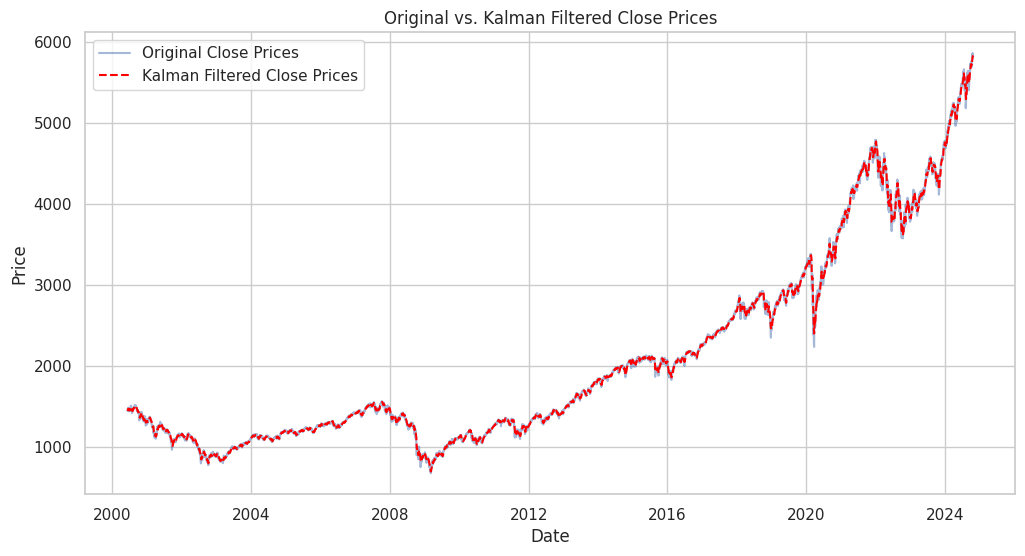

In [19]:
# Plot the original and smoothed data
plt.figure(figsize=(12, 6))
plt.plot(data_copy.index, data_copy['Close'], label='Original Close Prices', alpha=0.5)
plt.plot(data_copy.index, data_copy['Kalman_Filtered_Close'], label='Kalman Filtered Close Prices', color='red', linestyle='--')
plt.title('Original vs. Kalman Filtered Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
# Compute correlation matrix
corr_matrix = data_copy.corr()
display(corr_matrix['Close'].sort_values(ascending=False))

,Close
Close,1.000000
Kalman_Filtered_Close,0.999768
Close_lag_1,0.999768
Close_lag_2,0.999577
Close_lag_3,0.999371
Close_lag_4,0.999171
EMA_20,0.999154
Close_lag_5,0.998981
20_MA,0.998808
BB_low,0.998560


# Prepare the Data

## Split the Data

In [21]:
# Define window and prediction lengths
window_length = 60  # Past 60 time steps
pred_length = 1  # Predict next time step

# Calculate total samples
total_samples = len(data) - window_length - pred_length + 1
print(f"Total samples available: {total_samples}")

Total samples available: 6180


In [22]:
# Calculate split sizes
train_size = int(0.7 * total_samples)  # 70% training
val_size = int(0.15 * total_samples)   # 15% validation
test_size = total_samples - train_size - val_size  # 15% testing

print(f"Training samples: {train_size}, Validation samples: {val_size}, Testing samples: {test_size}")

Training samples: 4326, Validation samples: 927, Testing samples: 927


In [23]:
def create_splits(df, train_size, val_size, test_size):
    """
    Splits the DataFrame into training, validation, and testing sets without overlapping.

    Args:
        df (pd.DataFrame): The input DataFrame.
        train_size (int): Number of training samples.
        val_size (int): Number of validation samples.
        test_size (int): Number of testing samples.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Train, Validation, Test DataFrames.
    """
    # Training data includes the first 'train_size' samples
    train_data = df.iloc[:train_size]

    # Validation data starts after training data and includes 'val_size' samples
    val_start = train_size
    val_end = train_size + val_size
    val_data = df.iloc[val_start:val_end]

    # Testing data starts after validation data and includes 'test_size' samples
    test_start = val_end
    test_end = val_end + test_size
    test_data = df.iloc[test_start:test_end]

    return train_data, val_data, test_data

In [24]:
# Create splits
train_data, val_data, test_data = create_splits(
    data,
    train_size,
    val_size,
    test_size
)

# Display the first few rows of each split to verify
print("Training Data:")
display(train_data.head(10))
display(train_data.tail(10))

print("\n\nValidation Data:")
display(val_data.head(10))
display(val_data.tail(10))

print("\n\nTesting Data:")
display(test_data.head(10))
display(test_data.tail(10))

Training Data:


,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
2000-01-10,1457.599976
2000-01-11,1438.560059
2000-01-12,1432.250000
2000-01-13,1449.680054


,Close
Date,
2017-03-01,2395.959961
2017-03-02,2381.919922
2017-03-03,2383.120117
2017-03-06,2375.310059
2017-03-07,2368.389893
2017-03-08,2362.979980
2017-03-09,2364.870117
2017-03-10,2372.600098
2017-03-13,2373.469971




Validation Data:


,Close
Date,
2017-03-15,2385.260010
2017-03-16,2381.379883
2017-03-17,2378.250000
2017-03-20,2373.469971
2017-03-21,2344.020020
2017-03-22,2348.449951
2017-03-23,2345.959961
2017-03-24,2343.979980
2017-03-27,2341.590088


,Close
Date,
2020-11-03,3369.159912
2020-11-04,3443.439941
2020-11-05,3510.449951
2020-11-06,3509.439941
2020-11-09,3550.500000
2020-11-10,3545.530029
2020-11-11,3572.659912
2020-11-12,3537.010010
2020-11-13,3585.149902




Testing Data:


,Close
Date,
2020-11-17,3609.530029
2020-11-18,3567.790039
2020-11-19,3581.870117
2020-11-20,3557.540039
2020-11-23,3577.590088
2020-11-24,3635.409912
2020-11-25,3629.649902
2020-11-27,3638.350098
2020-11-30,3621.629883


,Close
Date,
2024-07-15,5631.220215
2024-07-16,5667.200195
2024-07-17,5588.270020
2024-07-18,5544.589844
2024-07-19,5505.000000
2024-07-22,5564.410156
2024-07-23,5555.740234
2024-07-24,5427.129883
2024-07-25,5399.220215


In [25]:
def plot_train_val_test_splits(data, train_size, val_size, test_size, title="Train, Validation, Test Splits"):
    """
    Visualizes the training, validation, and testing splits on the original data.

    Args:
        data (pd.DataFrame): Original data with 'Close' and time-based features, 'Date' as index.
        train_size (int): Number of training samples.
        val_size (int): Number of validation samples.
        test_size (int): Number of testing samples.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14,7))

    # Define split indices
    train_end_idx = train_size
    val_end_idx = train_size + val_size
    test_end_idx = train_size + val_size + test_size

    # Plot training set
    plt.plot(data.index[:train_end_idx], data['Close'][:train_end_idx], label='Training Set', color='blue', linestyle='-')

    # Plot validation set
    plt.plot(data.index[train_end_idx:val_end_idx], data['Close'][train_end_idx:val_end_idx], label='Validation Set', color='orange', linestyle='--')

    # Plot testing set
    plt.plot(data.index[val_end_idx:test_end_idx], data['Close'][val_end_idx:test_end_idx], label='Testing Set', color='green', linestyle='-.')

    # Plot split lines
    if train_end_idx < len(data):
        train_end_date = data.index[train_end_idx-1]
        plt.axvline(x=train_end_date, color='red', linestyle=':', label='Train/Val Split')
    if val_end_idx < len(data):
        val_end_date = data.index[val_end_idx-1]
        plt.axvline(x=val_end_date, color='purple', linestyle=':', label='Val/Test Split')

    # Formatting the date axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

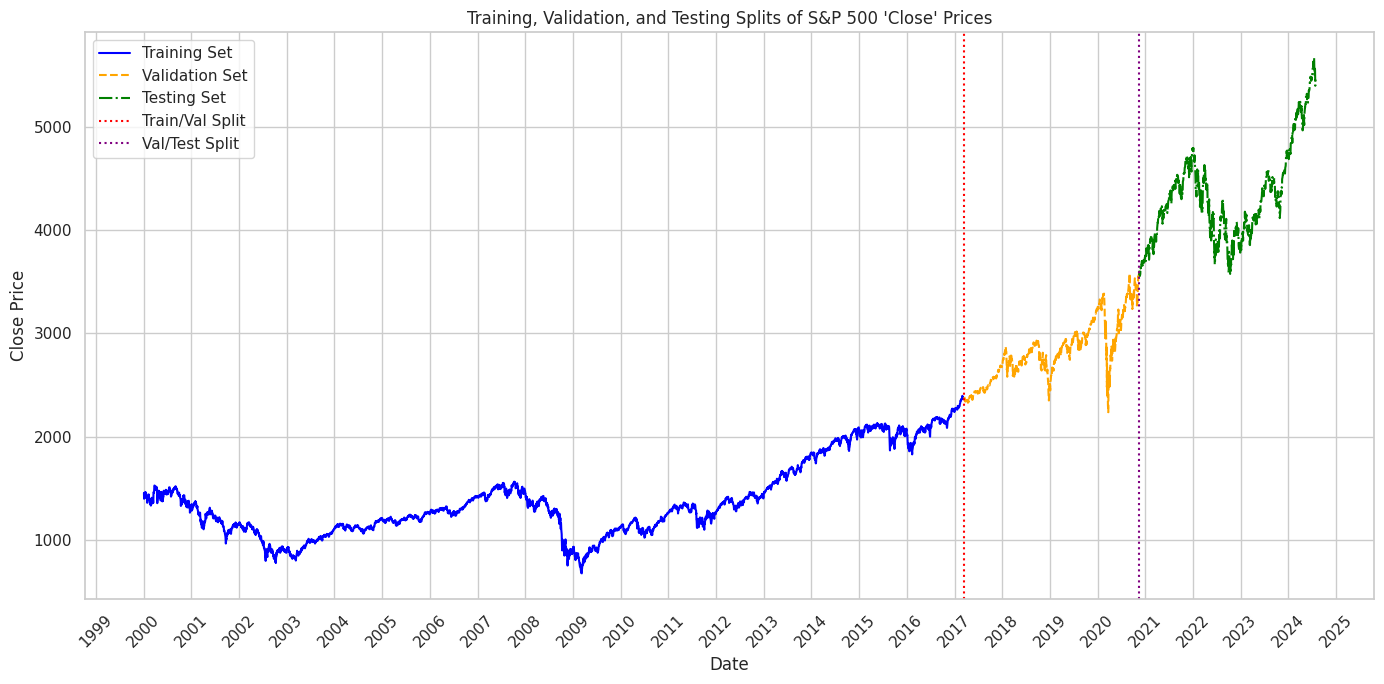

In [26]:
# Plot the splits
plot_train_val_test_splits(
    data=data,
    train_size=train_size,
    val_size=val_size,
    test_size=test_size,
    title="Training, Validation, and Testing Splits of S&P 500 'Close' Prices"
)

## Difference the Data

In [27]:
def difference_splits(train_df, val_df, test_df, column='Close'):
    """
    Applies first-order differencing to training, validation, and testing splits.

    Args:
        train_df (pd.DataFrame): Training data.
        val_df (pd.DataFrame): Validation data.
        test_df (pd.DataFrame): Testing data.
        column (str): Column name to difference.

    Returns:
        Tuple[pd.Series, pd.Series, pd.Series, float, float]:
            - Differenced training data
            - Differenced validation data
            - Differenced testing data
            - Last actual value from training set
            - Last actual value from validation set
    """
    # Difference training data
    differenced_train = train_df[column].diff().dropna()

    # Get the last actual value from training set for differencing validation set
    last_train_value = train_df[column].iloc[-1]

    # Difference validation data
    # The first differenced value in validation set = val[0] - last_train_value
    val_diff_first = val_df[column].iloc[0] - last_train_value
    differenced_val = val_df[column].diff().dropna()
    differenced_val.iloc[0] = val_diff_first  # Replace the first NaN with the actual difference

    # Get the last actual value from validation set for differencing testing set
    last_val_value = val_df[column].iloc[-1]

    # Difference testing data
    # The first differenced value in testing set = test[0] - last_val_value
    test_diff_first = test_df[column].iloc[0] - last_val_value
    differenced_test = test_df[column].diff().dropna()
    differenced_test.iloc[0] = test_diff_first  # Replace the first NaN with the actual difference

    return differenced_train, differenced_val, differenced_test, last_train_value, last_val_value

In [28]:
# Apply differencing
differenced_train, differenced_val, differenced_test, last_train, last_val = difference_splits(
    train_data,
    val_data,
    test_data,
    column='Close'
)

# Display the first few rows of the differenced splits
print("Differenced Training Data:")
display(differenced_train.head(10))
display(differenced_train.tail(10))

print("\nDifferenced Validation Data:")
display(differenced_val.head(10))
display(differenced_val.tail(10))

print("\nDifferenced Testing Data:")
display(differenced_test.head(10))
display(differenced_test.tail(10))

Differenced Training Data:


,Close
Date,
2000-01-04,-55.799927
2000-01-05,2.689941
2000-01-06,1.339966
2000-01-07,38.020020
2000-01-10,16.130005
2000-01-11,-19.039917
2000-01-12,-6.310059
2000-01-13,17.430054
2000-01-14,15.469971


,Close
Date,
2017-03-01,32.320068
2017-03-02,-14.040039
2017-03-03,1.200195
2017-03-06,-7.810059
2017-03-07,-6.920166
2017-03-08,-5.409912
2017-03-09,1.890137
2017-03-10,7.729980
2017-03-13,0.869873



Differenced Validation Data:


,Close
Date,
2017-03-16,19.810059
2017-03-17,-3.129883
2017-03-20,-4.780029
2017-03-21,-29.449951
2017-03-22,4.429932
2017-03-23,-2.489990
2017-03-24,-1.979980
2017-03-27,-2.389893
2017-03-28,16.979980


,Close
Date,
2020-11-03,58.919922
2020-11-04,74.280029
2020-11-05,67.010010
2020-11-06,-1.010010
2020-11-09,41.060059
2020-11-10,-4.969971
2020-11-11,27.129883
2020-11-12,-35.649902
2020-11-13,48.139893



Differenced Testing Data:


,Close
Date,
2020-11-18,-17.379883
2020-11-19,14.080078
2020-11-20,-24.330078
2020-11-23,20.050049
2020-11-24,57.819824
2020-11-25,-5.760010
2020-11-27,8.700195
2020-11-30,-16.720215
2020-12-01,40.820068


,Close
Date,
2024-07-15,15.870117
2024-07-16,35.979980
2024-07-17,-78.930176
2024-07-18,-43.680176
2024-07-19,-39.589844
2024-07-22,59.410156
2024-07-23,-8.669922
2024-07-24,-128.610352
2024-07-25,-27.909668


In [29]:
def plot_differenced_splits(differenced_train, differenced_val, differenced_test,
                           train_end_date, val_end_date, title="Differenced Train, Validation, and Test Splits"):
    """
    Visualizes the differenced training, validation, and testing splits.

    Args:
        differenced_train (pd.Series): Differenced training data.
        differenced_val (pd.Series): Differenced validation data.
        differenced_test (pd.Series): Differenced testing data.
        train_end_date (datetime.date): The last date of the training set.
        val_end_date (datetime.date): The last date of the validation set.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 7))

    # Plot differenced training data
    plt.plot(differenced_train.index, differenced_train.values, label='Training Set', color='blue')

    # Plot differenced validation data
    plt.plot(differenced_val.index, differenced_val.values, label='Validation Set', color='orange')

    # Plot differenced testing data
    plt.plot(differenced_test.index, differenced_test.values, label='Testing Set', color='green')

    # Add vertical lines to indicate split points
    plt.axvline(x=train_end_date, color='red', linestyle='--', label='Train/Validation Split')
    plt.axvline(x=val_end_date, color='purple', linestyle='--', label='Validation/Test Split')

    # Formatting the date axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Differenced Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

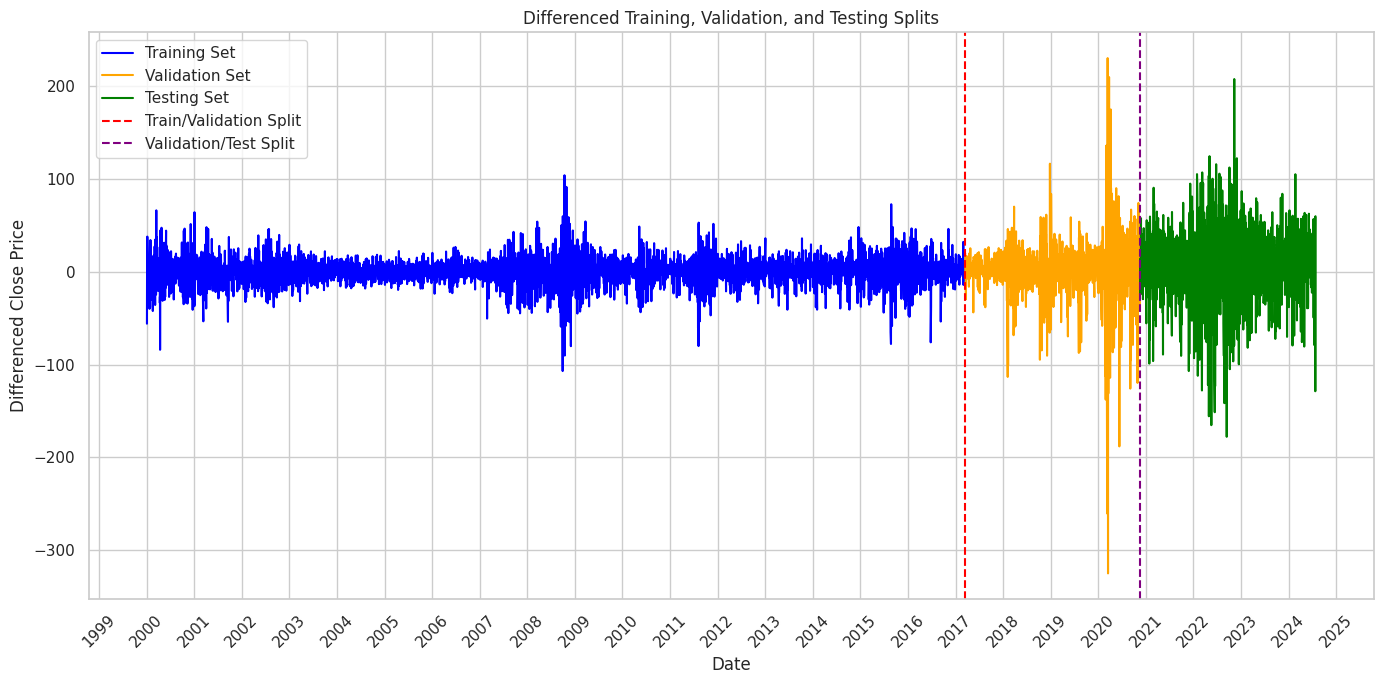

In [30]:
# Extract end dates for visualization
train_end_date = train_data.index[-1]
val_end_date = val_data.index[-1]

# Visualize the differenced splits
plot_differenced_splits(
    differenced_train=differenced_train,
    differenced_val=differenced_val,
    differenced_test=differenced_test,
    train_end_date=train_end_date,
    val_end_date=val_end_date,
    title="Differenced Training, Validation, and Testing Splits"
)

In [31]:
def check_stationarity(series, significance_level=0.05):
    """
    Performs the Augmented Dickey-Fuller test to check stationarity.

    Args:
        series (pd.Series): The time series data.
        significance_level (float): The significance level for the test.

    Returns:
        bool: True if the series is stationary, False otherwise.
    """
    result = adfuller(series)
    p_value = result[1]
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {p_value:.4f}")
    return p_value < significance_level

In [32]:
# Check stationarity
print("Checking stationarity of Differenced Training Data:")
is_stationary_train = check_stationarity(differenced_train)
print(f"Training data is stationary: {is_stationary_train}\n")

print("Checking stationarity of Differenced Validation Data:")
is_stationary_val = check_stationarity(differenced_val)
print(f"Validation data is stationary: {is_stationary_val}\n")

print("Checking stationarity of Differenced Testing Data:")
is_stationary_test = check_stationarity(differenced_test)
print(f"Testing data is stationary: {is_stationary_test}")

Checking stationarity of Differenced Training Data:
ADF Statistic: -15.9435
p-value: 0.0000
Training data is stationary: True

Checking stationarity of Differenced Validation Data:
ADF Statistic: -8.5844
p-value: 0.0000
Validation data is stationary: True

Checking stationarity of Differenced Testing Data:
ADF Statistic: -22.7744
p-value: 0.0000
Testing data is stationary: True


## Scale the Data

In [33]:
def scale_splits(differenced_train, differenced_val, differenced_test):
    """
    Scales the differenced training, validation, and testing splits using standardization.

    Args:
        differenced_train (pd.Series): Differenced training data.
        differenced_val (pd.Series): Differenced validation data.
        differenced_test (pd.Series): Differenced testing data.

    Returns:
        Tuple[pd.Series, pd.Series, pd.Series, StandardScaler]:
            - Scaled training data
            - Scaled validation data
            - Scaled testing data
            - Fitted StandardScaler object
    """
    scaler = StandardScaler()

    # Reshape data for scaler
    train_values = differenced_train.values.reshape(-1, 1)
    val_values = differenced_val.values.reshape(-1, 1)
    test_values = differenced_test.values.reshape(-1, 1)

    # Fit scaler on training data
    scaler.fit(train_values)

    # Transform all splits
    scaled_train = pd.Series(scaler.transform(train_values).flatten(), index=differenced_train.index, name='Close_Diff_Scaled')
    scaled_val = pd.Series(scaler.transform(val_values).flatten(), index=differenced_val.index, name='Close_Diff_Scaled')
    scaled_test = pd.Series(scaler.transform(test_values).flatten(), index=differenced_test.index, name='Close_Diff_Scaled')

    return scaled_train, scaled_val, scaled_test, scaler

In [34]:
# Scale the differenced splits
scaled_train, scaled_val, scaled_test, scaler = scale_splits(
    differenced_train,
    differenced_val,
    differenced_test
)

# Display the first few rows of the scaled splits
print("Scaled Training Data:")
display(scaled_train.head(10))
display(scaled_train.tail(10))

print("\nScaled Validation Data:")
display(scaled_val.head(10))
display(scaled_val.tail(10))

print("\nScaled Testing Data:")
display(scaled_test.head(10))
display(scaled_test.tail(10))

Scaled Training Data:


,Close_Diff_Scaled
Date,
2000-01-04,-3.707043
2000-01-05,0.164104
2000-01-06,0.074756
2000-01-07,2.502423
2000-01-10,1.053634
2000-01-11,-1.274085
2000-01-12,-0.431560
2000-01-13,1.139678
2000-01-14,1.009950


,Close_Diff_Scaled
Date,
2017-03-01,2.125172
2017-03-02,-0.943168
2017-03-03,0.065506
2017-03-06,-0.530837
2017-03-07,-0.471940
2017-03-08,-0.371984
2017-03-09,0.111169
2017-03-10,0.497679
2017-03-13,0.043643



Scaled Validation Data:


,Close_Diff_Scaled
Date,
2017-03-16,1.297198
2017-03-17,-0.221080
2017-03-20,-0.330295
2017-03-21,-1.963072
2017-03-22,0.279266
2017-03-23,-0.178729
2017-03-24,-0.144974
2017-03-27,-0.172104
2017-03-28,1.109890


,Close_Diff_Scaled
Date,
2020-11-03,3.885682
2020-11-04,4.902289
2020-11-05,4.421124
2020-11-06,-0.080777
2020-11-09,2.703628
2020-11-10,-0.342866
2020-11-11,1.781660
2020-11-12,-2.373415
2020-11-13,3.172206



Scaled Testing Data:


,Close_Diff_Scaled
Date,
2020-11-18,-1.164215
2020-11-19,0.917960
2020-11-20,-1.624214
2020-11-23,1.313082
2020-11-24,3.812872
2020-11-25,-0.395155
2020-11-27,0.561893
2020-11-30,-1.120555
2020-12-01,2.687744


,Close_Diff_Scaled
Date,
2024-07-15,1.036433
2024-07-16,2.367403
2024-07-17,-5.237917
2024-07-18,-2.904898
2024-07-19,-2.634180
2024-07-22,3.918128
2024-07-23,-0.587747
2024-07-24,-8.525996
2024-07-25,-1.861129


In [35]:
def plot_scaled_splits(scaled_train, scaled_val, scaled_test,
                      train_end_date, val_end_date, title="Scaled Train, Validation, and Test Splits"):
    """
    Visualizes the scaled training, validation, and testing splits.

    Args:
        scaled_train (pd.Series): Scaled training data.
        scaled_val (pd.Series): Scaled validation data.
        scaled_test (pd.Series): Scaled testing data.
        train_end_date (datetime.date): The last date of the training set.
        val_end_date (datetime.date): The last date of the validation set.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 7))

    # Plot scaled training data
    plt.plot(scaled_train.index, scaled_train.values, label='Training Set', color='blue')

    # Plot scaled validation data
    plt.plot(scaled_val.index, scaled_val.values, label='Validation Set', color='orange')

    # Plot scaled testing data
    plt.plot(scaled_test.index, scaled_test.values, label='Testing Set', color='green')

    # Add vertical lines to indicate split points
    plt.axvline(x=train_end_date, color='red', linestyle='--', label='Train/Validation Split')
    plt.axvline(x=val_end_date, color='purple', linestyle='--', label='Validation/Test Split')

    # Formatting the date axis
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Scaled Differenced Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

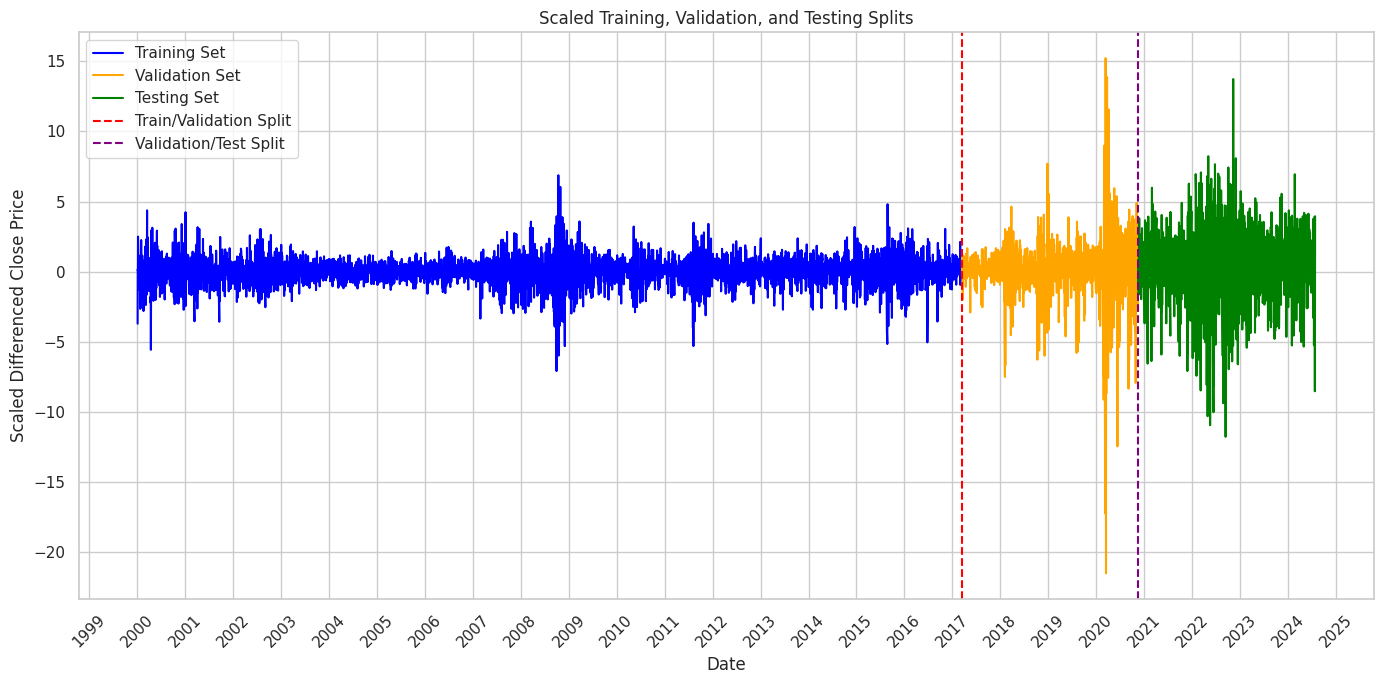

In [36]:
# Extract end dates for visualization
train_end_date = train_data.index[-1]
val_end_date = val_data.index[-1]

# Plot the scaled splits
plot_scaled_splits(
    scaled_train=scaled_train,
    scaled_val=scaled_val,
    scaled_test=scaled_test,
    train_end_date=train_end_date,
    val_end_date=val_end_date,
    title="Scaled Training, Validation, and Testing Splits"
)

## Add Time Features

In [37]:
def add_time_features_to_splits(scaled_train, scaled_val, scaled_test):
    """
    Adds time-based features to the scaled training, validation, and testing splits.

    Args:
        scaled_train (pd.Series): Scaled differenced training data with Date as index.
        scaled_val (pd.Series): Scaled differenced validation data with Date as index.
        scaled_test (pd.Series): Scaled differenced testing data with Date as index.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
            - Scaled training DataFrame with time-based features
            - Scaled validation DataFrame with time-based features
            - Scaled testing DataFrame with time-based features
    """
    def add_time_features(df):
        """
        Adds time-based features to a single DataFrame based on the Date index.

        Args:
            df (pd.Series): Scaled differenced data with Date as index.

        Returns:
            pd.DataFrame: DataFrame with 'Close_Diff_Scaled' and time-based features.
        """
        df = df.copy()
        df = df.to_frame()  # Convert Series to DataFrame

        # Ensure the index is in datetime format
        df.index = pd.to_datetime(df.index)

        # Add time-based features
        df['month'] = df.index.month
        df['day'] = df.index.day
        df['day_of_week'] = df.index.dayofweek
        df['quarter'] = df.index.quarter
        df['year'] = df.index.year

        return df

    # Apply to each split
    scaled_train_df = add_time_features(scaled_train)
    scaled_val_df = add_time_features(scaled_val)
    scaled_test_df = add_time_features(scaled_test)

    return scaled_train_df, scaled_val_df, scaled_test_df

In [38]:
# Add time-based features to each split
scaled_train_df, scaled_val_df, scaled_test_df = add_time_features_to_splits(scaled_train, scaled_val, scaled_test)

# Display the first few rows of each split with time-based features
print("Scaled Training Data with Time-Based Features:")
display(scaled_train_df.head(10))
display(scaled_train_df.tail(10))

print("\nScaled Validation Data with Time-Based Features:")
display(scaled_val_df.head(10))
display(scaled_val_df.tail(10))

print("\nScaled Testing Data with Time-Based Features:")
display(scaled_test_df.head(10))
display(scaled_test_df.tail(10))

Scaled Training Data with Time-Based Features:


,Close_Diff_Scaled,month,day,day_of_week,quarter,year
Date,,,,,,
2000-01-04,-3.707043,1,4,1,1,2000
2000-01-05,0.164104,1,5,2,1,2000
2000-01-06,0.074756,1,6,3,1,2000
2000-01-07,2.502423,1,7,4,1,2000
2000-01-10,1.053634,1,10,0,1,2000
2000-01-11,-1.274085,1,11,1,1,2000
2000-01-12,-0.431560,1,12,2,1,2000
2000-01-13,1.139678,1,13,3,1,2000
2000-01-14,1.009950,1,14,4,1,2000


,Close_Diff_Scaled,month,day,day_of_week,quarter,year
Date,,,,,,
2017-03-01,2.125172,3,1,2,1,2017
2017-03-02,-0.943168,3,2,3,1,2017
2017-03-03,0.065506,3,3,4,1,2017
2017-03-06,-0.530837,3,6,0,1,2017
2017-03-07,-0.471940,3,7,1,1,2017
2017-03-08,-0.371984,3,8,2,1,2017
2017-03-09,0.111169,3,9,3,1,2017
2017-03-10,0.497679,3,10,4,1,2017
2017-03-13,0.043643,3,13,0,1,2017



Scaled Validation Data with Time-Based Features:


,Close_Diff_Scaled,month,day,day_of_week,quarter,year
Date,,,,,,
2017-03-16,1.297198,3,16,3,1,2017
2017-03-17,-0.221080,3,17,4,1,2017
2017-03-20,-0.330295,3,20,0,1,2017
2017-03-21,-1.963072,3,21,1,1,2017
2017-03-22,0.279266,3,22,2,1,2017
2017-03-23,-0.178729,3,23,3,1,2017
2017-03-24,-0.144974,3,24,4,1,2017
2017-03-27,-0.172104,3,27,0,1,2017
2017-03-28,1.109890,3,28,1,1,2017


,Close_Diff_Scaled,month,day,day_of_week,quarter,year
Date,,,,,,
2020-11-03,3.885682,11,3,1,4,2020
2020-11-04,4.902289,11,4,2,4,2020
2020-11-05,4.421124,11,5,3,4,2020
2020-11-06,-0.080777,11,6,4,4,2020
2020-11-09,2.703628,11,9,0,4,2020
2020-11-10,-0.342866,11,10,1,4,2020
2020-11-11,1.781660,11,11,2,4,2020
2020-11-12,-2.373415,11,12,3,4,2020
2020-11-13,3.172206,11,13,4,4,2020



Scaled Testing Data with Time-Based Features:


,Close_Diff_Scaled,month,day,day_of_week,quarter,year
Date,,,,,,
2020-11-18,-1.164215,11,18,2,4,2020
2020-11-19,0.917960,11,19,3,4,2020
2020-11-20,-1.624214,11,20,4,4,2020
2020-11-23,1.313082,11,23,0,4,2020
2020-11-24,3.812872,11,24,1,4,2020
2020-11-25,-0.395155,11,25,2,4,2020
2020-11-27,0.561893,11,27,4,4,2020
2020-11-30,-1.120555,11,30,0,4,2020
2020-12-01,2.687744,12,1,1,4,2020


,Close_Diff_Scaled,month,day,day_of_week,quarter,year
Date,,,,,,
2024-07-15,1.036433,7,15,0,3,2024
2024-07-16,2.367403,7,16,1,3,2024
2024-07-17,-5.237917,7,17,2,3,2024
2024-07-18,-2.904898,7,18,3,3,2024
2024-07-19,-2.634180,7,19,4,3,2024
2024-07-22,3.918128,7,22,0,3,2024
2024-07-23,-0.587747,7,23,1,3,2024
2024-07-24,-8.525996,7,24,2,3,2024
2024-07-25,-1.861129,7,25,3,3,2024


## Create Sequences

In [39]:
def create_sequences_encoder_only(df, window_length=60, prediction_length=1):
    """
    Creates input-output sequences for time series forecasting.

    Args:
        df (pd.DataFrame): DataFrame containing 'Close_Diff_Scaled' and time-based features.
        window_length (int): Number of past time steps to include in each input sequence.
        prediction_length (int): Number of future time steps to predict.

    Returns:
        Tuple[np.ndarray, np.ndarray]:
            - X: Input sequences of shape (num_samples, window_length, num_features)
            - y: Target values of shape (num_samples, prediction_length)
    """
    X = []
    y = []

    # Number of total samples that can be created
    total_samples = len(df) - window_length - prediction_length + 1

    # Iterate through the DataFrame to create sequences
    for i in range(total_samples):
        # Define the start and end of the input sequence
        start = i
        end = i + window_length

        # Extract input sequence (all columns except target)
        input_seq = df.iloc[start:end].values

        # Extract target sequence (only 'Close_Diff_Scaled')
        target_seq = df.iloc[end:end + prediction_length]['Close_Diff_Scaled'].values

        X.append(input_seq)
        y.append(target_seq)

    # Convert lists to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

In [40]:
# Create sequences for training set
X_train, y_train = create_sequences_encoder_only(scaled_train_df, window_length=60, prediction_length=1)
print(f"Training Sequences - X: {X_train.shape}, y: {y_train.shape}")

# Create sequences for validation set
X_val, y_val = create_sequences_encoder_only(scaled_val_df, window_length=60, prediction_length=1)
print(f"Validation Sequences - X: {X_val.shape}, y: {y_val.shape}")

# Create sequences for testing set
X_test, y_test = create_sequences_encoder_only(scaled_test_df, window_length=60, prediction_length=1)
print(f"Testing Sequences - X: {X_test.shape}, y: {y_test.shape}")

Training Sequences - X: (4265, 60, 6), y: (4265, 1)
Validation Sequences - X: (866, 60, 6), y: (866, 1)
Testing Sequences - X: (866, 60, 6), y: (866, 1)


In [41]:
def verify_sequences_encoder_only(X, y, split_name=""):
    """
    Verifies the correctness of the created sequences.

    Args:
        X (np.ndarray): Input sequences.
        y (np.ndarray): Target values.
        split_name (str): Name of the split (e.g., 'Training', 'Validation', 'Testing').

    Returns:
        None
    """
    print(f"Verification for {split_name} Split:")
    print(f" - Number of sequences: {X.shape[0]}")
    print(f" - Input shape: {X.shape}")  # (num_samples, window_length, num_features)
    print(f" - Target shape: {y.shape}")  # (num_samples, prediction_length)\n")

    # Check that the first input sequence corresponds to the first window_length data points
    first_input = X[0]
    first_target = y[0]

    print(f"\nFirst Input Sequence (first 5 time steps):")
    print(first_input[:5])  # Show first 5 time steps of the first sequence

    print(f"\nFirst Target Value:")
    print(first_target)

    # Check that the last input sequence corresponds to the last window_length data points before the target
    last_input = X[-1]
    last_target = y[-1]

    print(f"\nLast Input Sequence (last 5 time steps):")
    print(last_input[-5:])  # Show last 5 time steps of the last sequence

    print(f"\nLast Target Value:")
    print(last_target)

    print("\n" + "-"*50 + "\n")

In [42]:
# Verify training sequences
verify_sequences_encoder_only(X_train, y_train, split_name="Training")

# Verify validation sequences
verify_sequences_encoder_only(X_val, y_val, split_name="Validation")

# Verify testing sequences
verify_sequences_encoder_only(X_test, y_test, split_name="Testing")

Verification for Training Split:
 - Number of sequences: 4265
 - Input shape: (4265, 60, 6)
 - Target shape: (4265, 1)

First Input Sequence (first 5 time steps):
[[-3.70704336e+00  1.00000000e+00  4.00000000e+00  1.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 1.64104448e-01  1.00000000e+00  5.00000000e+00  2.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 7.47564089e-02  1.00000000e+00  6.00000000e+00  3.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 2.50242318e+00  1.00000000e+00  7.00000000e+00  4.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 1.05363410e+00  1.00000000e+00  1.00000000e+01  0.00000000e+00
   1.00000000e+00  2.00000000e+03]]

First Target Value:
[-1.37733707]

Last Input Sequence (last 5 time steps):
[[-4.71939836e-01  3.00000000e+00  7.00000000e+00  1.00000000e+00
   1.00000000e+00  2.01700000e+03]
 [-3.71983787e-01  3.00000000e+00  8.00000000e+00  2.00000000e+00
   1.00000000e+00  2.01700000e+03]
 [ 1.11169431e-01  3.00000000e+00  9.00000000e+00  3

In [43]:
def create_sequences_encoder_decoder(df, window_length=60, prediction_length=1):
    """
    Creates input-output sequences for time series forecasting.

    Args:
        df (pd.DataFrame): DataFrame containing 'Close_Diff_Scaled' and time-based features.
        window_length (int): Number of past time steps to include in each input sequence.
        prediction_length (int): Number of future time steps to predict.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]:
            - encoder_X: Sequences for the encoder of shape (num_samples, window_length, num_features)
            - decoder_X: Sequences for the decoder of shape (num_samples, prediction_length, num_features)
            - y: Target values of shape (num_samples, prediction_length)
    """
    encoder_X = []
    decoder_X = []
    y = []

    # Number of total samples that can be created
    total_samples = len(df) - window_length - prediction_length + 1

    # Iterate through the DataFrame to create sequences
    for i in range(total_samples):
        # Define the start and end of the input sequence
        start = i
        end = i + window_length

        # Extract input sequence (all columns except target)
        enc_seq = df.iloc[start:end].values
        dec_seq = df.iloc[end:end+prediction_length].values

        # Extract target sequence (only 'Close_Diff_Scaled')
        target_seq = df.iloc[end:end + prediction_length]['Close_Diff_Scaled'].values

        encoder_X.append(enc_seq)
        decoder_X.append(dec_seq)
        y.append(target_seq)

    # Convert lists to NumPy arrays
    encoder_X = np.array(encoder_X)
    decoder_X = np.array(decoder_X)
    y = np.array(y)

    return encoder_X, decoder_X, y

In [44]:
# Create sequences for training set
encoder_X_train, decoder_X_train, y_train_new = create_sequences_encoder_decoder(scaled_train_df, window_length=60, prediction_length=1)
print(f"Training Sequences - encoder_X: {encoder_X_train.shape}, decoder_X: {decoder_X_train.shape}, y: {y_train_new.shape}")

# Create sequences for validation set
encoder_X_val, decoder_X_val, y_val_new = create_sequences_encoder_decoder(scaled_val_df, window_length=60, prediction_length=1)
print(f"Validation Sequences - encoder_X: {encoder_X_val.shape}, decoder_X: {decoder_X_val.shape}, y: {y_val_new.shape}")

# Create sequences for testing set
encoder_X_test, decoder_X_test, y_test_new = create_sequences_encoder_decoder(scaled_test_df, window_length=60, prediction_length=1)
print(f"Testing Sequences - encoder_X: {encoder_X_test.shape}, decoder_X: {decoder_X_test.shape}, y: {y_test_new.shape}")

Training Sequences - encoder_X: (4265, 60, 6), decoder_X: (4265, 1, 6), y: (4265, 1)
Validation Sequences - encoder_X: (866, 60, 6), decoder_X: (866, 1, 6), y: (866, 1)
Testing Sequences - encoder_X: (866, 60, 6), decoder_X: (866, 1, 6), y: (866, 1)


In [45]:
def verify_sequences_encoder_decoder(encoder_X, decoder_X, y, split_name=""):
    """
    Verifies the correctness of the created sequences.

    Args:
        encoder_X (np.ndarray): Encoder sequences.
        decoder_X (np.ndarray): Decoder sequences.
        y (np.ndarray): Target values.
        split_name (str): Name of the split (e.g., 'Training', 'Validation', 'Testing').

    Returns:
        None
    """
    print(f"Verification for {split_name} Split:")
    print(f" - Number of encoder sequences: {encoder_X.shape[0]}")
    print(f" - Number of decoder sequences: {decoder_X.shape[0]}")
    print(f" - Encoder input shape: {encoder_X.shape}")  # (num_samples, window_length, num_features)
    print(f" - Decoder input shape: {decoder_X.shape}")  # (num_samples, prediction_length, num_features)
    print(f" - Target shape: {y.shape}")  # (num_samples, prediction_length)\n")

    # Check that the first input sequence corresponds to the first window_length data points
    first_enc_input = encoder_X[0]
    first_dec_input = decoder_X[0]
    first_target = y[0]

    print(f"\nFirst Encoder Input Sequence (first 5 time steps):")
    print(first_enc_input[:5])  # Show first 5 time steps of the first sequence

    print(f"\nFirst Decoder Input Sequence (first 5 time steps):")
    print(first_dec_input[:5])  # Show first 5 time steps of the first sequence

    print(f"\nFirst Target Value:")
    print(first_target)

    # Check that the last input sequence corresponds to the last window_length data points before the target
    last_enc_input = encoder_X[-1]
    last_dec_input = decoder_X[-1]
    last_target = y[-1]

    print(f"\nLast Encoder Input Sequence (last 5 time steps):")
    print(last_enc_input[-5:])  # Show last 5 time steps of the last sequence

    print(f"\nLast Decoder Input Sequence (last 5 time steps):")
    print(last_dec_input[-5:])  # Show last 5 time steps of the last sequence

    print(f"\nLast Target Value:")
    print(last_target)

    print("\n" + "-"*50 + "\n")

In [46]:
# Verify training sequences
verify_sequences_encoder_decoder(encoder_X_train, decoder_X_train, y_train_new, split_name="Training")

# Verify validation sequences
verify_sequences_encoder_decoder(encoder_X_val, decoder_X_val, y_val_new, split_name="Validation")

# Verify testing sequences
verify_sequences_encoder_decoder(encoder_X_test, decoder_X_test, y_test_new, split_name="Testing")

Verification for Training Split:
 - Number of encoder sequences: 4265
 - Number of decoder sequences: 4265
 - Encoder input shape: (4265, 60, 6)
 - Decoder input shape: (4265, 1, 6)
 - Target shape: (4265, 1)

First Encoder Input Sequence (first 5 time steps):
[[-3.70704336e+00  1.00000000e+00  4.00000000e+00  1.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 1.64104448e-01  1.00000000e+00  5.00000000e+00  2.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 7.47564089e-02  1.00000000e+00  6.00000000e+00  3.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 2.50242318e+00  1.00000000e+00  7.00000000e+00  4.00000000e+00
   1.00000000e+00  2.00000000e+03]
 [ 1.05363410e+00  1.00000000e+00  1.00000000e+01  0.00000000e+00
   1.00000000e+00  2.00000000e+03]]

First Decoder Input Sequence (first 5 time steps):
[[-1.37733707e+00  3.00000000e+00  3.00000000e+01  3.00000000e+00
   1.00000000e+00  2.00000000e+03]]

First Target Value:
[-1.37733707]

Last Encoder Input Sequence (last 5 time st

## Create Datasets

In [47]:
def create_pytorch_dataset_encoder_only(X, y):
    """
    Creates a PyTorch Dataset from input and target sequences.

    Args:
        X (np.ndarray): Input sequences of shape (num_samples, window_length, num_features).
        y (np.ndarray): Target sequences of shape (num_samples, prediction_length).

    Returns:
        torch.utils.data.TensorDataset: PyTorch Dataset containing inputs and targets.
    """
    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create a TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)

    return dataset

In [48]:
# Create PyTorch Datasets
train_dataset_encoder_only = create_pytorch_dataset_encoder_only(X_train, y_train)
val_dataset_encoder_only = create_pytorch_dataset_encoder_only(X_val, y_val)
test_dataset_encoder_only = create_pytorch_dataset_encoder_only(X_test, y_test)

# Display the first sample from each Dataset
print("Sample from Training Dataset:")
print(train_dataset_encoder_only[0])

print("\nSample from Validation Dataset:")
print(val_dataset_encoder_only[0])

print("\nSample from Testing Dataset:")
print(test_dataset_encoder_only[0])

Sample from Training Dataset:
(tensor([[-3.7070e+00,  1.0000e+00,  4.0000e+00,  1.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.6410e-01,  1.0000e+00,  5.0000e+00,  2.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 7.4756e-02,  1.0000e+00,  6.0000e+00,  3.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 2.5024e+00,  1.0000e+00,  7.0000e+00,  4.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.0536e+00,  1.0000e+00,  1.0000e+01,  0.0000e+00,  1.0000e+00,
          2.0000e+03],
        [-1.2741e+00,  1.0000e+00,  1.1000e+01,  1.0000e+00,  1.0000e+00,
          2.0000e+03],
        [-4.3156e-01,  1.0000e+00,  1.2000e+01,  2.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.1397e+00,  1.0000e+00,  1.3000e+01,  3.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.0099e+00,  1.0000e+00,  1.4000e+01,  4.0000e+00,  1.0000e+00,
          2.0000e+03],
        [-6.7644e-01,  1.0000e+00,  1.8000e+01,  1.0000e+00,  1.0000e+00,
          2.0000e+03],

In [49]:
def verify_pytorch_dataset_encoder_only(dataset, split_name=""):
    """
    Verifies the correctness of a PyTorch Dataset.

    Args:
        dataset (torch.utils.data.Dataset): The PyTorch Dataset to verify.
        split_name (str): Name of the split (e.g., 'Training', 'Validation', 'Testing').

    Returns:
        None
    """
    print(f"Verification for {split_name} Dataset:")
    print(f" - Number of samples: {len(dataset)}")

    # Fetch the first sample
    X_sample, y_sample = dataset[0]
    print(f" - First sample X shape: {X_sample.shape}")
    print(f" - First sample y shape: {y_sample.shape}")

    # Fetch the last sample
    X_last, y_last = dataset[-1]
    print(f" - Last sample X shape: {X_last.shape}")
    print(f" - Last sample y shape: {y_last.shape}")

    print("\n" + "-"*50 + "\n")

In [50]:
# Verify Training Dataset
verify_pytorch_dataset_encoder_only(train_dataset_encoder_only, split_name="Training")

# Verify Validation Dataset
verify_pytorch_dataset_encoder_only(val_dataset_encoder_only, split_name="Validation")

# Verify Testing Dataset
verify_pytorch_dataset_encoder_only(test_dataset_encoder_only, split_name="Testing")

Verification for Training Dataset:
 - Number of samples: 4265
 - First sample X shape: torch.Size([60, 6])
 - First sample y shape: torch.Size([1])
 - Last sample X shape: torch.Size([60, 6])
 - Last sample y shape: torch.Size([1])

--------------------------------------------------

Verification for Validation Dataset:
 - Number of samples: 866
 - First sample X shape: torch.Size([60, 6])
 - First sample y shape: torch.Size([1])
 - Last sample X shape: torch.Size([60, 6])
 - Last sample y shape: torch.Size([1])

--------------------------------------------------

Verification for Testing Dataset:
 - Number of samples: 866
 - First sample X shape: torch.Size([60, 6])
 - First sample y shape: torch.Size([1])
 - Last sample X shape: torch.Size([60, 6])
 - Last sample y shape: torch.Size([1])

--------------------------------------------------



In [51]:
def create_pytorch_dataset_encoder_decoder(encoder_X, decoder_X, y):
    """
    Creates a PyTorch Dataset from input and target sequences.

    Args:
        encoder_X (np.ndarray): Sequences of shape (num_samples, window_length, num_features).
        decoder_X (np.ndarray): Sequences of shape (num_samples, prediction_length, num_features).
        y (np.ndarray): Target sequences of shape (num_samples, prediction_length).

    Returns:
        torch.utils.data.TensorDataset: PyTorch Dataset containing inputs and targets.
    """
    # Convert numpy arrays to PyTorch tensors
    encoder_X_tensor = torch.tensor(encoder_X, dtype=torch.float32)
    decoder_X_tensor = torch.tensor(decoder_X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Create a TensorDataset
    dataset = TensorDataset(encoder_X_tensor, decoder_X_tensor, y_tensor)

    return dataset

In [52]:
# Create PyTorch Datasets
train_dataset_encoder_decoder = create_pytorch_dataset_encoder_decoder(encoder_X_train, decoder_X_train, y_train_new)
val_dataset_encoder_decoder = create_pytorch_dataset_encoder_decoder(encoder_X_val, decoder_X_val, y_val_new)
test_dataset_encoder_decoder = create_pytorch_dataset_encoder_decoder(encoder_X_test, decoder_X_test, y_test_new)

# Display the first sample from each Dataset
print("Sample from Training Dataset:")
print(train_dataset_encoder_decoder[0])

print("\nSample from Validation Dataset:")
print(val_dataset_encoder_decoder[0])

print("\nSample from Testing Dataset:")
print(test_dataset_encoder_decoder[0])

Sample from Training Dataset:
(tensor([[-3.7070e+00,  1.0000e+00,  4.0000e+00,  1.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.6410e-01,  1.0000e+00,  5.0000e+00,  2.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 7.4756e-02,  1.0000e+00,  6.0000e+00,  3.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 2.5024e+00,  1.0000e+00,  7.0000e+00,  4.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.0536e+00,  1.0000e+00,  1.0000e+01,  0.0000e+00,  1.0000e+00,
          2.0000e+03],
        [-1.2741e+00,  1.0000e+00,  1.1000e+01,  1.0000e+00,  1.0000e+00,
          2.0000e+03],
        [-4.3156e-01,  1.0000e+00,  1.2000e+01,  2.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.1397e+00,  1.0000e+00,  1.3000e+01,  3.0000e+00,  1.0000e+00,
          2.0000e+03],
        [ 1.0099e+00,  1.0000e+00,  1.4000e+01,  4.0000e+00,  1.0000e+00,
          2.0000e+03],
        [-6.7644e-01,  1.0000e+00,  1.8000e+01,  1.0000e+00,  1.0000e+00,
          2.0000e+03],

In [53]:
def verify_pytorch_dataset_encoder_decoder(dataset, split_name=""):
    """
    Verifies the correctness of a PyTorch Dataset.

    Args:
        dataset (torch.utils.data.Dataset): The PyTorch Dataset to verify.
        split_name (str): Name of the split (e.g., 'Training', 'Validation', 'Testing').

    Returns:
        None
    """
    print(f"Verification for {split_name} Dataset:")
    print(f" - Number of samples: {len(dataset)}")

    # Fetch the first sample
    encoder_X_sample, decoder_X_sample, y_sample = dataset[0]
    print(f" - First sample encoder_X shape: {encoder_X_sample.shape}")
    print(f" - First sample decoder_X shape: {decoder_X_sample.shape}")
    print(f" - First sample y shape: {y_sample.shape}")

    # Fetch the last sample
    encoder_X_last, decoder_X_last, y_last = dataset[-1]
    print(f" - Last sample encoder_X shape: {encoder_X_last.shape}")
    print(f" - Last sample decoder_X shape: {decoder_X_last.shape}")
    print(f" - Last sample y shape: {y_last.shape}")

    print("\n" + "-"*50 + "\n")

In [54]:
# Verify Training Dataset
verify_pytorch_dataset_encoder_decoder(train_dataset_encoder_decoder, split_name="Training")

# Verify Validation Dataset
verify_pytorch_dataset_encoder_decoder(val_dataset_encoder_decoder, split_name="Validation")

# Verify Testing Dataset
verify_pytorch_dataset_encoder_decoder(test_dataset_encoder_decoder, split_name="Testing")

Verification for Training Dataset:
 - Number of samples: 4265
 - First sample encoder_X shape: torch.Size([60, 6])
 - First sample decoder_X shape: torch.Size([1, 6])
 - First sample y shape: torch.Size([1])
 - Last sample encoder_X shape: torch.Size([60, 6])
 - Last sample decoder_X shape: torch.Size([1, 6])
 - Last sample y shape: torch.Size([1])

--------------------------------------------------

Verification for Validation Dataset:
 - Number of samples: 866
 - First sample encoder_X shape: torch.Size([60, 6])
 - First sample decoder_X shape: torch.Size([1, 6])
 - First sample y shape: torch.Size([1])
 - Last sample encoder_X shape: torch.Size([60, 6])
 - Last sample decoder_X shape: torch.Size([1, 6])
 - Last sample y shape: torch.Size([1])

--------------------------------------------------

Verification for Testing Dataset:
 - Number of samples: 866
 - First sample encoder_X shape: torch.Size([60, 6])
 - First sample decoder_X shape: torch.Size([1, 6])
 - First sample y shape: t

## Create DataLoaders

In [55]:
def create_dataloaders_encoder_only(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=32,
    shuffle_train=True,
    shuffle_val=False,
    shuffle_test=False,
    num_workers=0
):
    """
    Creates PyTorch DataLoader objects for training, validation, and testing datasets.

    Args:
        train_dataset (torch.utils.data.Dataset): Training Dataset.
        val_dataset (torch.utils.data.Dataset): Validation Dataset.
        test_dataset (torch.utils.data.Dataset): Testing Dataset.
        batch_size (int): Number of samples per batch.
        shuffle_train (bool): Whether to shuffle the training data.
        shuffle_val (bool): Whether to shuffle the validation data.
        shuffle_test (bool): Whether to shuffle the testing data.
        num_workers (int): Number of subprocesses to use for data loading.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: Training, Validation, Testing DataLoaders.
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=shuffle_val,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=shuffle_test,
        num_workers=num_workers
    )

    return train_loader, val_loader, test_loader

In [56]:
# Create PyTorch DataLoaders
train_loader_encoder_only, val_loader_encoder_only, test_loader_encoder_only = create_dataloaders_encoder_only(
    train_dataset_encoder_only,
    val_dataset_encoder_only,
    test_dataset_encoder_only,
    batch_size=32,
    shuffle_train=True,
    shuffle_val=False,
    shuffle_test=False,
    num_workers=0
)

# Display the first batch from each DataLoader
print("First Batch from Training DataLoader:")
for X_batch, y_batch in train_loader_encoder_only:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

print("\nFirst Batch from Validation DataLoader:")
for X_batch, y_batch in val_loader_encoder_only:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

print("\nFirst Batch from Testing DataLoader:")
for X_batch, y_batch in test_loader_encoder_only:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

First Batch from Training DataLoader:
X_batch shape: torch.Size([32, 60, 6])
y_batch shape: torch.Size([32, 1])

First Batch from Validation DataLoader:
X_batch shape: torch.Size([32, 60, 6])
y_batch shape: torch.Size([32, 1])

First Batch from Testing DataLoader:
X_batch shape: torch.Size([32, 60, 6])
y_batch shape: torch.Size([32, 1])


In [57]:
def verify_dataloaders_encoder_only(train_loader, val_loader, test_loader):
    """
    Verifies the correctness of PyTorch DataLoader objects.

    Args:
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        test_loader (DataLoader): Testing DataLoader.

    Returns:
        None
    """
    print("Verification for Training DataLoader:")
    for X_batch, y_batch in train_loader:
        print(f" - Batch size: {X_batch.size(0)}")
        print(f" - X_batch shape: {X_batch.shape}")
        print(f" - y_batch shape: {y_batch.shape}")
        break  # Only check the first batch

    print("\nVerification for Validation DataLoader:")
    for X_batch, y_batch in val_loader:
        print(f" - Batch size: {X_batch.size(0)}")
        print(f" - X_batch shape: {X_batch.shape}")
        print(f" - y_batch shape: {y_batch.shape}")
        break  # Only check the first batch

    print("\nVerification for Testing DataLoader:")
    for X_batch, y_batch in test_loader:
        print(f" - Batch size: {X_batch.size(0)}")
        print(f" - X_batch shape: {X_batch.shape}")
        print(f" - y_batch shape: {y_batch.shape}")
        break  # Only check the first batch

In [58]:
# Verify the DataLoaders
verify_dataloaders_encoder_only(
    train_loader_encoder_only,
    val_loader_encoder_only,
    test_loader_encoder_only
)

Verification for Training DataLoader:
 - Batch size: 32
 - X_batch shape: torch.Size([32, 60, 6])
 - y_batch shape: torch.Size([32, 1])

Verification for Validation DataLoader:
 - Batch size: 32
 - X_batch shape: torch.Size([32, 60, 6])
 - y_batch shape: torch.Size([32, 1])

Verification for Testing DataLoader:
 - Batch size: 32
 - X_batch shape: torch.Size([32, 60, 6])
 - y_batch shape: torch.Size([32, 1])


In [59]:
def create_dataloaders_encoder_decoder(
    train_dataset,
    val_dataset,
    test_dataset,
    batch_size=32,
    shuffle_train=True,
    shuffle_val=False,
    shuffle_test=False,
    num_workers=0
):
    """
    Creates PyTorch DataLoader objects for training, validation, and testing datasets.

    Args:
        train_dataset (torch.utils.data.Dataset): Training Dataset.
        val_dataset (torch.utils.data.Dataset): Validation Dataset.
        test_dataset (torch.utils.data.Dataset): Testing Dataset.
        batch_size (int): Number of samples per batch.
        shuffle_train (bool): Whether to shuffle the training data.
        shuffle_val (bool): Whether to shuffle the validation data.
        shuffle_test (bool): Whether to shuffle the testing data.
        num_workers (int): Number of subprocesses to use for data loading.

    Returns:
        Tuple[DataLoader, DataLoader, DataLoader]: Training, Validation, Testing DataLoaders.
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=shuffle_train,
        num_workers=num_workers
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=shuffle_val,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=shuffle_test,
        num_workers=num_workers
    )

    return train_loader, val_loader, test_loader

In [60]:
# Create PyTorch DataLoaders
train_loader_encoder_decoder, val_loader_encoder_decoder, test_loader_encoder_decoder = create_dataloaders_encoder_decoder(
    train_dataset_encoder_decoder,
    val_dataset_encoder_decoder,
    test_dataset_encoder_decoder,
    batch_size=32,
    shuffle_train=True,
    shuffle_val=False,
    shuffle_test=False,
    num_workers=0
)

# Display the first batch from each DataLoader
print("First Batch from Training DataLoader:")
for encoder_X_batch, decoder_X_batch, y_batch in train_loader_encoder_decoder:
    print("encoder_X_batch shape:", encoder_X_batch.shape)
    print("decoder_X_batch shape:", decoder_X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

print("\nFirst Batch from Validation DataLoader:")
for encoder_X_batch, decoder_X_batch, y_batch in val_loader_encoder_decoder:
    print("encoder_X_batch shape:", encoder_X_batch.shape)
    print("decoder_X_batch shape:", decoder_X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

print("\nFirst Batch from Testing DataLoader:")
for encoder_X_batch, decoder_X_batch, y_batch in test_loader_encoder_decoder:
    print("encoder_X_batch shape:", encoder_X_batch.shape)
    print("decoder_X_batch shape:", decoder_X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break

First Batch from Training DataLoader:
encoder_X_batch shape: torch.Size([32, 60, 6])
decoder_X_batch shape: torch.Size([32, 1, 6])
y_batch shape: torch.Size([32, 1])

First Batch from Validation DataLoader:
encoder_X_batch shape: torch.Size([32, 60, 6])
decoder_X_batch shape: torch.Size([32, 1, 6])
y_batch shape: torch.Size([32, 1])

First Batch from Testing DataLoader:
encoder_X_batch shape: torch.Size([32, 60, 6])
decoder_X_batch shape: torch.Size([32, 1, 6])
y_batch shape: torch.Size([32, 1])


In [61]:
def verify_dataloaders_encoder_decoder(train_loader, val_loader, test_loader):
    """
    Verifies the correctness of PyTorch DataLoader objects.

    Args:
        train_loader (DataLoader): Training DataLoader.
        val_loader (DataLoader): Validation DataLoader.
        test_loader (DataLoader): Testing DataLoader.

    Returns:
        None
    """
    print("Verification for Training DataLoader:")
    for encoder_X_batch, decoder_X_batch, y_batch in train_loader:
        print(f" - Batch size: {encoder_X_batch.size(0)}")
        print(f" - encoder_X_batch shape: {encoder_X_batch.shape}")
        print(f" - decoder_X_batch shape: {decoder_X_batch.shape}")
        print(f" - y_batch shape: {y_batch.shape}")
        break  # Only check the first batch

    print("\nVerification for Validation DataLoader:")
    for encoder_X_batch, decoder_X_batch, y_batch in val_loader:
        print(f" - Batch size: {encoder_X_batch.size(0)}")
        print(f" - encoder_X_batch shape: {encoder_X_batch.shape}")
        print(f" - decoder_X_batch shape: {decoder_X_batch.shape}")
        print(f" - y_batch shape: {y_batch.shape}")
        break  # Only check the first batch

    print("\nVerification for Testing DataLoader:")
    for encoder_X_batch, decoder_X_batch, y_batch in test_loader:
        print(f" - Batch size: {encoder_X_batch.size(0)}")
        print(f" - encoder_X_batch shape: {encoder_X_batch.shape}")
        print(f" - decoder_X_batch shape: {decoder_X_batch.shape}")
        print(f" - y_batch shape: {y_batch.shape}")
        break  # Only check the first batch

In [62]:
# Verify the DataLoaders
verify_dataloaders_encoder_decoder(
    train_loader_encoder_decoder,
    val_loader_encoder_decoder,
    test_loader_encoder_decoder
)

Verification for Training DataLoader:
 - Batch size: 32
 - encoder_X_batch shape: torch.Size([32, 60, 6])
 - decoder_X_batch shape: torch.Size([32, 1, 6])
 - y_batch shape: torch.Size([32, 1])

Verification for Validation DataLoader:
 - Batch size: 32
 - encoder_X_batch shape: torch.Size([32, 60, 6])
 - decoder_X_batch shape: torch.Size([32, 1, 6])
 - y_batch shape: torch.Size([32, 1])

Verification for Testing DataLoader:
 - Batch size: 32
 - encoder_X_batch shape: torch.Size([32, 60, 6])
 - decoder_X_batch shape: torch.Size([32, 1, 6])
 - y_batch shape: torch.Size([32, 1])


# Define the Model

In [63]:
class CategoricalFeatureEmbedding(nn.Module):
    def __init__(self, categorical_cardinalities, embedding_dims, start_indices=None):
        """
        Initializes the CategoricalFeatureEmbedding module.

        Args:
            categorical_cardinalities (list): Number of unique categories for each categorical feature.
            embedding_dims (list): Embedding dimensions for each categorical feature.
            start_indices (list, optional): Starting index for each categorical feature.
                                            Defaults to 0 for all features.
        """
        super(CategoricalFeatureEmbedding, self).__init__()

        assert len(categorical_cardinalities) == len(embedding_dims), \
            "categorical_cardinalities and embedding_dims must be of the same length."

        self.num_features = len(categorical_cardinalities)
        # If start_indices not provided, default to 0 for all features
        if start_indices is None:
            self.start_indices = [0] * self.num_features
        else:
            assert len(start_indices) == self.num_features, \
                "Length of start_indices must match number of categorical features."
            self.start_indices = start_indices

        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, embed_dim)
            for num_categories, embed_dim in zip(categorical_cardinalities, embedding_dims)
        ])

    def forward(self, x):
        """
        Forward pass for categorical embeddings.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_length, num_categorical_features).

        Returns:
            Tensor: Embedded tensor of shape (batch_size, seq_length, total_embedding_dim).
        """
        embedded = []
        for i, embedding in enumerate(self.embeddings):
            # Extract the i-th categorical feature
            cat_feat = x[:, :, i]  # Shape: (batch_size, seq_length)
            # Adjust indices by subtracting the start_index
            cat_feat_adj = cat_feat - self.start_indices[i]

            # Clamp indices to [0, num_embeddings - 1] to handle unseen categories gracefully
            unknown_idx = embedding.num_embeddings - 1
            cat_feat_adj = torch.clamp(cat_feat_adj, 0, unknown_idx)

            # Ensure indices are within [0, num_embeddings - 1]
            if (cat_feat_adj < 0).any() or (cat_feat_adj > unknown_idx).any():
                raise ValueError(
                    f"Categorical feature {i} has values outside the expected range after adjustment. "
                    f"Adjusted min={cat_feat_adj.min().item()}, Adjusted max={cat_feat_adj.max().item()}, "
                    f"Embedding num_embeddings={embedding.num_embeddings}"
                )

            # Embed the adjusted categorical feature
            embed = embedding(cat_feat_adj)  # Shape: (batch_size, seq_length, embedding_dim)
            embedded.append(embed)

        # Concatenate all embedded categorical features along the last dimension
        embedded = torch.cat(embedded, dim=-1)  # Shape: (batch_size, seq_length, total_embedding_dim)
        return embedded

In [64]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        """
        Initializes the PositionalEncoding module.

        Args:
            d_model (int): The dimension of the embeddings.
            max_len (int): The maximum length of sequences.
        """
        super(PositionalEncoding, self).__init__()

        # Create a positional encoding matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))  # Shape: (d_model/2,)

        # Apply sinusoidal functions to even and odd indices
        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices

        # Add a batch dimension and register as buffer to prevent updates during training
        pe = pe.unsqueeze(0).transpose(0, 1)  # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Adds positional encoding to the input tensor.

        Args:
            x (Tensor): Input tensor of shape (seq_len, batch_size, d_model).

        Returns:
            Tensor: Tensor with positional encoding added.
        """
        x = x + self.pe[:x.size(0), :]
        return x

In [65]:
class EncoderOnlyTransformer(nn.Module):
    def __init__(
        self,
        numerical_features,
        categorical_features,
        categorical_cardinalities,
        embedding_dims,
        start_indices,
        d_model=512,
        nhead=8,
        num_encoder_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        max_seq_length=60
    ):
        """
        Initializes the Encoder-Only Transformer model.

        Args:
            numerical_features (int): Number of numerical input features.
            categorical_features (list): List of categorical feature names.
            categorical_cardinalities (list): Number of unique categories for each categorical feature.
            embedding_dims (list): Embedding dimensions for each categorical feature.
            start_indices (list): Starting index for each categorical feature.
            d_model (int): Embedding dimension for the Transformer.
            nhead (int): Number of attention heads.
            num_encoder_layers (int): Number of Transformer encoder layers.
            dim_feedforward (int): Dimension of the feedforward network.
            dropout (float): Dropout rate.
            max_seq_length (int): Maximum sequence length.
        """
        super(EncoderOnlyTransformer, self).__init__()

        assert len(categorical_features) == len(categorical_cardinalities) == len(embedding_dims), \
            "Length of categorical_features, categorical_cardinalities, and embedding_dims must be equal."

        self.d_model = d_model
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.num_categorical = len(categorical_features)

        # Categorical Embeddings with start_indices
        self.categorical_embedding = CategoricalFeatureEmbedding(
            categorical_cardinalities=categorical_cardinalities,
            embedding_dims=embedding_dims,
            start_indices=start_indices
        )

        # Calculate the total embedding dimension for categorical features
        total_embedding_dim = sum(embedding_dims)

        # Projection layer for numerical features
        self.numerical_projection = nn.Linear(numerical_features, d_model - total_embedding_dim)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_seq_length)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Final output layer for regression
        self.output_layer = nn.Linear(d_model, 1)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """
        Initializes weights of the model.
        """
        initrange = 0.1
        # Initialize numerical projection layer
        nn.init.uniform_(self.numerical_projection.weight, -initrange, initrange)
        nn.init.zeros_(self.numerical_projection.bias)
        # Initialize output layer
        nn.init.uniform_(self.output_layer.weight, -initrange, initrange)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, x):
        """
        Forward pass of the Encoder-Only Transformer model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_length, num_features).

        Returns:
            Tensor: Output predictions of shape (batch_size, 1).
        """
        batch_size, seq_length, num_features = x.size()

        # Separate numerical and categorical features
        numerical = x[:, :, :self.numerical_features]  # Shape: (batch_size, seq_length, numerical_features)
        categorical = x[:, :, self.numerical_features:].long()  # Shape: (batch_size, seq_length, num_categorical_features)

        # Embed categorical features
        embedded_categorical = self.categorical_embedding(categorical)  # Shape: (batch_size, seq_length, total_embedding_dim)

        # Project numerical features
        projected_numerical = self.numerical_projection(numerical)  # Shape: (batch_size, seq_length, d_model - total_embedding_dim)

        # Concatenate numerical projections with embedded categorical features
        combined = torch.cat([projected_numerical, embedded_categorical], dim=-1)  # Shape: (batch_size, seq_length, d_model)

        # Apply dropout
        combined = self.dropout(combined)

        # Permute for Transformer (seq_length, batch_size, d_model)
        combined = combined.permute(1, 0, 2)  # Shape: (seq_length, batch_size, d_model)

        # Add positional encoding
        combined = self.positional_encoding(combined)  # Shape: (seq_length, batch_size, d_model)

        # Pass through Transformer Encoder
        memory = self.transformer_encoder(combined)  # Shape: (seq_length, batch_size, d_model)

        # Extract the output from the last time step
        out = memory[-1, :, :]  # Shape: (batch_size, d_model)

        # Final output layer
        out = self.output_layer(out)  # Shape: (batch_size, 1)

        return out

In [66]:
class EncoderDecoderTransformer(nn.Module):
    def __init__(
        self,
        numerical_features,
        categorical_features,
        categorical_cardinalities,
        embedding_dims,
        start_indices,
        d_model=512,
        nhead=8,
        num_encoder_layers=6,
        num_decoder_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        max_seq_length=60,
        forecast_horizon=1
    ):
        """
        Initializes the Encoder-Decoder Transformer model.

        Args:
            numerical_features (int): Number of numerical input features.
            categorical_features (list): List of categorical feature names.
            categorical_cardinalities (list): Number of unique categories for each categorical feature.
            embedding_dims (list): Embedding dimensions for each categorical feature.
            start_indices (list): Starting index for each categorical feature.
            d_model (int): Embedding dimension for the Transformer.
            nhead (int): Number of attention heads.
            num_encoder_layers (int): Number of Transformer encoder layers.
            num_decoder_layers (int): Number of Transformer decoder layers.
            dim_feedforward (int): Dimension of the feedforward network.
            dropout (float): Dropout rate.
            max_seq_length (int): Maximum sequence length.
            forecast_horizon (int): Number of steps to forecast ahead.
        """
        super(EncoderDecoderTransformer, self).__init__()

        assert len(categorical_features) == len(categorical_cardinalities) == len(embedding_dims), \
            "Length of categorical_features, categorical_cardinalities, and embedding_dims must be equal."

        self.d_model = d_model
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.num_categorical = len(categorical_features)
        self.forecast_horizon = forecast_horizon

        # Categorical Embeddings with start_indices
        self.categorical_embedding = CategoricalFeatureEmbedding(
            categorical_cardinalities=categorical_cardinalities,
            embedding_dims=embedding_dims,
            start_indices=start_indices
        )

        # Calculate the total embedding dimension for categorical features
        total_embedding_dim = sum(embedding_dims)

        # Projection layer for numerical features
        self.numerical_projection = nn.Linear(numerical_features, d_model - total_embedding_dim)

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_seq_length + forecast_horizon)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Final output layer for regression
        self.output_layer = nn.Linear(d_model, forecast_horizon)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """
        Initializes weights of the model.
        """
        initrange = 0.1
        # Initialize numerical projection layer
        nn.init.uniform_(self.numerical_projection.weight, -initrange, initrange)
        nn.init.zeros_(self.numerical_projection.bias)
        # Initialize output layer
        nn.init.uniform_(self.output_layer.weight, -initrange, initrange)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, encoder_x, decoder_x):
        """
        Forward pass of the Encoder-Decoder Transformer model.

        Args:
            encoder_x (Tensor): Encoder input tensor of shape (batch_size, seq_length, num_features).
            decoder_x (Tensor): Decoder input tensor of shape (batch_size, forecast_horizon, num_features).

        Returns:
            Tensor: Output predictions of shape (batch_size, forecast_horizon).
        """
        batch_size, encoder_seq_length, num_features = encoder_x.size()
        batch_size, decoder_seq_length, num_features = decoder_x.size()

        # Process Encoder Input
        numerical_enc = encoder_x[:, :, :self.numerical_features]  # Shape: (batch_size, seq_length, numerical_features)
        categorical_enc = encoder_x[:, :, self.numerical_features:].long()  # Shape: (batch_size, seq_length, num_categorical_features)

        embedded_categorical_enc = self.categorical_embedding(categorical_enc)  # Shape: (batch_size, seq_length, total_embedding_dim)
        projected_numerical_enc = self.numerical_projection(numerical_enc)    # Shape: (batch_size, seq_length, d_model - total_embedding_dim)

        combined_enc = torch.cat([projected_numerical_enc, embedded_categorical_enc], dim=-1)  # Shape: (batch_size, seq_length, d_model)
        combined_enc = self.dropout(combined_enc)
        combined_enc = combined_enc.permute(1, 0, 2)  # Shape: (seq_length, batch_size, d_model)
        combined_enc = self.positional_encoding(combined_enc)  # Shape: (seq_length, batch_size, d_model)

        memory = self.transformer_encoder(combined_enc)  # Shape: (seq_length, batch_size, d_model)

        # Process Decoder Input
        numerical_dec = decoder_x[:, :, :self.numerical_features]  # Shape: (batch_size, forecast_horizon, numerical_features)
        categorical_dec = decoder_x[:, :, self.numerical_features:].long()  # Shape: (batch_size, forecast_horizon, num_categorical_features)

        embedded_categorical_dec = self.categorical_embedding(categorical_dec)  # Shape: (batch_size, forecast_horizon, total_embedding_dim)
        projected_numerical_dec = self.numerical_projection(numerical_dec)    # Shape: (batch_size, forecast_horizon, d_model - total_embedding_dim)

        combined_dec = torch.cat([projected_numerical_dec, embedded_categorical_dec], dim=-1)  # Shape: (batch_size, forecast_horizon, d_model)
        combined_dec = self.dropout(combined_dec)
        combined_dec = combined_dec.permute(1, 0, 2)  # Shape: (forecast_horizon, batch_size, d_model)
        combined_dec = self.positional_encoding(combined_dec)  # Shape: (forecast_horizon, batch_size, d_model)

        # Generate masks
        tgt_mask = self.generate_square_subsequent_mask(decoder_seq_length).to(encoder_x.device)

        # Pass through Transformer Decoder
        output = self.transformer_decoder(combined_dec, memory, tgt_mask=tgt_mask)  # Shape: (forecast_horizon, batch_size, d_model)

        # Permute back to (batch_size, forecast_horizon, d_model)
        output = output.permute(1, 0, 2)  # Shape: (batch_size, forecast_horizon, d_model)

        # Final output layer
        out = self.output_layer(output)  # Shape: (batch_size, forecast_horizon)

        return out

    def generate_square_subsequent_mask(self, sz):
        """
        Generates a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).

        Args:
            sz (int): Size of the mask (sequence length).

        Returns:
            Tensor: Mask tensor of shape (sz, sz).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [67]:
def initialize_models(
    numerical_features,
    categorical_features,
    categorical_cardinalities,
    embedding_dims,
    start_indices,
    d_model=512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048,
    dropout=0.1,
    window_length=60,
    pred_length=1,
    device=None
):
    """
    Initializes both Encoder-Only and Encoder-Decoder Transformer models.

    Args:
        numerical_features (int): Number of numerical input features.
        categorical_features (list): List of categorical feature names.
        categorical_cardinalities (list): Number of unique categories for each categorical feature.
        embedding_dims (list): Embedding dimensions for each categorical feature.
        start_indices (list): Starting index for each categorical feature.
        d_model (int): Embedding dimension for the Transformer.
        nhead (int): Number of attention heads.
        num_encoder_layers (int): Number of Transformer encoder layers.
        num_decoder_layers (int): Number of Transformer decoder layers.
        dim_feedforward (int): Dimension of the feedforward network.
        dropout (float): Dropout rate.
        window_length (int): Sequence length.
        pred_length (int): Number of steps to forecast ahead.
        device (torch.device): Device to move the models to. If None, defaults to CUDA if available.

    Returns:
        Tuple[nn.Module, nn.Module, torch.device]:
            - encoder_only_model
            - encoder_decoder_model
            - device
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize Encoder-Only Transformer
    encoder_only_model = EncoderOnlyTransformer(
        numerical_features=numerical_features,
        categorical_features=categorical_features,
        categorical_cardinalities=categorical_cardinalities,
        embedding_dims=embedding_dims,
        start_indices=start_indices,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        max_seq_length=window_length
    ).to(device)

    # Initialize Encoder-Decoder Transformer
    encoder_decoder_model = EncoderDecoderTransformer(
        numerical_features=numerical_features,
        categorical_features=categorical_features,
        categorical_cardinalities=categorical_cardinalities,
        embedding_dims=embedding_dims,
        start_indices=start_indices,
        d_model=d_model,
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dim_feedforward=dim_feedforward,
        dropout=dropout,
        max_seq_length=window_length,
        forecast_horizon=pred_length
    ).to(device)

    return encoder_only_model, encoder_decoder_model, device

In [68]:
# Define the features
numerical_features = 2  # 'Close_Diff_Scaled' and 'year'
categorical_features = ['month', 'day', 'day_of_week', 'quarter']

In [69]:
def inspect_categorical_features(data, categorical_features):
    """
    Inspects the unique values of categorical features to ensure they are within valid ranges.

    Args:
        data (pd.DataFrame): The dataset containing categorical features.
        categorical_features (list): List of categorical feature names.

    Raises:
        ValueError: If any categorical feature contains invalid values.
    """
    for feature in categorical_features:
        unique_values = sorted(data[feature].unique())
        print(f"Feature '{feature}' has {len(unique_values)} unique values.")
        print(f"Unique values: {unique_values}")

In [70]:
# Inspect categorical features
print("Training Set Categorical Features:")
inspect_categorical_features(scaled_train_df, categorical_features)

print("\nValidation Set Categorical Features:")
inspect_categorical_features(scaled_val_df, categorical_features)

print("\nTest Set Categorical Features:")
inspect_categorical_features(scaled_test_df, categorical_features)

Training Set Categorical Features:
Feature 'month' has 12 unique values.
Unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Feature 'day' has 31 unique values.
Unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Feature 'day_of_week' has 5 unique values.
Unique values: [0, 1, 2, 3, 4]
Feature 'quarter' has 4 unique values.
Unique values: [1, 2, 3, 4]

Validation Set Categorical Features:
Feature 'month' has 12 unique values.
Unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Feature 'day' has 31 unique values.
Unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Feature 'day_of_week' has 5 unique values.
Unique values: [0, 1, 2, 3, 4]
Feature 'quarter' has 4 unique values.
Unique values: [1, 2, 3, 4]

Test Set Categorical Features:
Feature 'month' has 12 unique values.
Unique values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [71]:
# Define cardinalities and embedding dimensions
categorical_cardinalities = [12, 31, 7, 4]
embedding_dims = [4, 8, 4, 2]  # Embedding dimensions for each categorical feature

# Define start_indices
start_indices = [1, 1, 0, 1]  # [month, day, day_of_week, quarter]

In [72]:
# Initialize the models
encoder_only_model, encoder_decoder_model, device = initialize_models(
    numerical_features=numerical_features,       # 'Close_Diff_Scaled' and 'year'
    categorical_features=categorical_features,   # ['month', 'day', 'day_of_week', 'quarter']
    categorical_cardinalities=categorical_cardinalities,  # [12, 31, 7, 4]
    embedding_dims=embedding_dims,               # [4, 8, 4, 2]
    start_indices=start_indices,                 # [1, 1, 0, 1]
    d_model=512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    dim_feedforward=2048,
    dropout=0.1,
    window_length=window_length,
    pred_length=pred_length
)

# Train the Model

In [73]:
# Define loss function
criterion_enc_only = nn.MSELoss()
criterion_enc_dec = nn.MSELoss()

# Define optimizers
optimizer_enc_only = optim.AdamW(encoder_only_model.parameters(), lr=0.001)
optimizer_enc_dec = optim.AdamW(encoder_decoder_model.parameters(), lr=0.001)

# Define checkpoint paths
checkpoint_path_enc_only = 'best_encoder_only_transformer.pth'
checkpoint_path_enc_dec = 'best_encoder_decoder_transformer.pth'

In [74]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    early_stopping_patience=10,
    scheduler_patience=5,
    gradient_clip_value=1.0,
    report_frequency=1,
    checkpoint_path='best_model.pth',
    model_type='encoder_only'
):
    """
    Trains the model with early stopping, gradient clipping, learning rate reduction upon plateau,
    and model checkpointing.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        num_epochs (int): Maximum number of epochs to train.
        early_stopping_patience (int): Number of epochs with no improvement after which training will be stopped.
        scheduler_patience (int): Number of epochs with no improvement after which learning rate will be reduced.
        gradient_clip_value (float): Maximum norm for gradient clipping.
        report_frequency (int): How often to report progress (e.g., every epoch, every 10 epochs).
        checkpoint_path (str): File path to save the best model.
        model_type (str): 'encoder_only' or 'encoder_decoder'.

    Returns:
        tuple: (model, history) where model is the trained model with the best weights loaded,
               and history is a dictionary containing training and validation losses.
    """
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           patience=scheduler_patience,
                                                           factor=0.1, verbose=False)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    early_stopping_counter = 0

    for epoch in range(1, num_epochs + 1):
        try:
            # Training Phase
            model.train()
            running_train_loss = 0.0

            if model_type == 'encoder_only':
                for X_batch, y_batch in train_loader:
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)

                    optimizer.zero_grad()
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()

                    # Gradient clipping
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)

                    optimizer.step()

                    running_train_loss += loss.item() * X_batch.size(0)
            elif model_type == 'encoder_decoder':
                for encoder_X_batch, decoder_X_batch, y_batch in train_loader:
                    encoder_X_batch = encoder_X_batch.to(device)
                    decoder_X_batch = decoder_X_batch.to(device)
                    y_batch = y_batch.to(device)

                    optimizer.zero_grad()
                    outputs = model(encoder_X_batch, decoder_X_batch)
                    loss = criterion(outputs, y_batch.squeeze(-1))
                    loss.backward()

                    # Gradient clipping
                    nn.utils.clip_grad_norm_(model.parameters(), gradient_clip_value)

                    optimizer.step()

                    running_train_loss += loss.item() * encoder_X_batch.size(0)
            else:
                raise ValueError("model_type must be 'encoder_only' or 'encoder_decoder'")

            epoch_train_loss = running_train_loss / len(train_loader.dataset)
            history['train_loss'].append(epoch_train_loss)

            # Validation Phase
            model.eval()
            running_val_loss = 0.0

            with torch.no_grad():
                if model_type == 'encoder_only':
                    for X_val, y_val in val_loader:
                        X_val = X_val.to(device)
                        y_val = y_val.to(device)

                        outputs = model(X_val)
                        loss = criterion(outputs, y_val)

                        running_val_loss += loss.item() * X_val.size(0)
                elif model_type == 'encoder_decoder':
                    for encoder_X_val, decoder_X_val, y_val in val_loader:
                        encoder_X_val = encoder_X_val.to(device)
                        decoder_X_val = decoder_X_val.to(device)
                        y_val = y_val.to(device)

                        outputs = model(encoder_X_val, decoder_X_val)
                        loss = criterion(outputs, y_val.squeeze(-1))

                        running_val_loss += loss.item() * encoder_X_val.size(0)
                else:
                    raise ValueError("model_type must be 'encoder_only' or 'encoder_decoder'")

            epoch_val_loss = running_val_loss / len(val_loader.dataset)
            history['val_loss'].append(epoch_val_loss)

            # Scheduler step
            scheduler.step(epoch_val_loss)

            # Current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            history['lr'].append(current_lr)

            # Check if learning rate was reduced
            if epoch > 1:
                if current_lr < history['lr'][-2]:
                    lr_reduced = True
                else:
                    lr_reduced = False
            else:
                lr_reduced = False

            # Check for improvement
            if epoch_val_loss < best_val_loss:
                best_val_loss = epoch_val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, checkpoint_path)
                early_stopping_counter = 0
                val_loss_decreased = True
            else:
                early_stopping_counter += 1
                val_loss_decreased = False

            # Reporting
            if epoch % report_frequency == 0:
                print(f"Epoch {epoch}/{num_epochs}")
                print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
                print(f"Learning Rate: {current_lr:.6f}")

                if lr_reduced:
                    print("Learning rate reduced.")

                if val_loss_decreased:
                    print("Validation loss decreased, saving model.")

                print("-" * 50)

            # Early stopping check
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping triggered after {epoch} epochs.")
                break

        except Exception as e:
            print(f"An error occurred during epoch {epoch}: {e}")
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print("Best model loaded.")

    return model, history

In [75]:
# Train Encoder-Only Transformer
print("Training Encoder-Only Transformer...")
trained_encoder_only, history_enc_only = train_model(
    model=encoder_only_model,
    train_loader=train_loader_encoder_only,
    val_loader=val_loader_encoder_only,
    criterion=criterion_enc_only,
    optimizer=optimizer_enc_only,
    num_epochs=100,
    early_stopping_patience=10,
    scheduler_patience=5,
    gradient_clip_value=1.0,
    report_frequency=1,
    checkpoint_path=checkpoint_path_enc_only,
    model_type='encoder_only'
)

Training Encoder-Only Transformer...
Epoch 1/100
Train Loss: 5.9456 | Val Loss: 6.5814
Learning Rate: 0.001000
Validation loss decreased, saving model.
--------------------------------------------------
Epoch 2/100
Train Loss: 1.0934 | Val Loss: 6.6004
Learning Rate: 0.001000
--------------------------------------------------
Epoch 3/100
Train Loss: 1.0654 | Val Loss: 6.4827
Learning Rate: 0.001000
Validation loss decreased, saving model.
--------------------------------------------------
Epoch 4/100
Train Loss: 1.0278 | Val Loss: 6.4779
Learning Rate: 0.001000
Validation loss decreased, saving model.
--------------------------------------------------
Epoch 5/100
Train Loss: 1.0279 | Val Loss: 6.4394
Learning Rate: 0.001000
Validation loss decreased, saving model.
--------------------------------------------------
Epoch 6/100
Train Loss: 1.0287 | Val Loss: 6.4459
Learning Rate: 0.001000
--------------------------------------------------
Epoch 7/100
Train Loss: 1.0032 | Val Loss: 6.4395

In [76]:
# Train Encoder-Decoder Transformer
print("Training Encoder-Decoder Transformer...")
trained_encoder_decoder, history_enc_dec = train_model(
    model=encoder_decoder_model,
    train_loader=train_loader_encoder_decoder,
    val_loader=val_loader_encoder_decoder,
    criterion=criterion_enc_dec,
    optimizer=optimizer_enc_dec,
    num_epochs=100,
    early_stopping_patience=10,
    scheduler_patience=5,
    gradient_clip_value=1.0,
    report_frequency=1,
    checkpoint_path=checkpoint_path_enc_dec,
    model_type='encoder_decoder'
)

Training Encoder-Decoder Transformer...
Epoch 1/100
Train Loss: 6.3696 | Val Loss: 6.4819
Learning Rate: 0.001000
Validation loss decreased, saving model.
--------------------------------------------------
Epoch 2/100
Train Loss: 1.0916 | Val Loss: 6.4715
Learning Rate: 0.001000
Validation loss decreased, saving model.
--------------------------------------------------
Epoch 3/100
Train Loss: 1.0271 | Val Loss: 6.4381
Learning Rate: 0.001000
Validation loss decreased, saving model.
--------------------------------------------------
Epoch 4/100
Train Loss: 1.0154 | Val Loss: 6.5193
Learning Rate: 0.001000
--------------------------------------------------
Epoch 5/100
Train Loss: 1.0141 | Val Loss: 6.4591
Learning Rate: 0.001000
--------------------------------------------------
Epoch 6/100
Train Loss: 1.0390 | Val Loss: 6.5285
Learning Rate: 0.001000
--------------------------------------------------
Epoch 7/100
Train Loss: 1.0115 | Val Loss: 6.4369
Learning Rate: 0.001000
Validation lo

# Forecast with Model

In [77]:
# Load best models
if os.path.exists(checkpoint_path_enc_only):
    trained_encoder_only.load_state_dict(torch.load(checkpoint_path_enc_only))
    trained_encoder_only.to(device)
    trained_encoder_only.eval()
    print("\nLoaded best Encoder-Only Transformer model from checkpoint.")
else:
    print("\nCheckpoint for Encoder-Only Transformer not found. Using current model weights.")

if os.path.exists(checkpoint_path_enc_dec):
    trained_encoder_decoder.load_state_dict(torch.load(checkpoint_path_enc_dec))
    trained_encoder_decoder.to(device)
    trained_encoder_decoder.eval()
    print("Loaded best Encoder-Decoder Transformer model from checkpoint.")
else:
    print("Checkpoint for Encoder-Decoder Transformer not found. Using current model weights.")


Loaded best Encoder-Only Transformer model from checkpoint.
Loaded best Encoder-Decoder Transformer model from checkpoint.


In [78]:
def get_predictions_encoder_only(model, test_loader, device):
    """
    Generates predictions using the trained Encoder-Only Transformer model on the testing data.

    Args:
        model (nn.Module): The trained Encoder-Only Transformer model.
        test_loader (DataLoader): DataLoader for the testing data.
        device (torch.device): Device where the model is located.

    Returns:
        np.ndarray: Array of raw predictions (scaled and differenced).
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())

    # Concatenate all batch predictions
    predictions = np.concatenate(predictions, axis=0).flatten()
    return predictions

In [79]:
def get_predictions_encoder_decoder(model, test_loader, device):
    """
    Generates predictions using the trained Encoder-Decoder Transformer model on the testing data.

    Args:
        model (nn.Module): The trained Encoder-Decoder Transformer model.
        test_loader (DataLoader): DataLoader for the testing data.
        device (torch.device): Device where the model is located.

    Returns:
        np.ndarray: Array of raw predictions (scaled and differenced).
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for encoder_X_batch, decoder_X_batch, _ in test_loader:
            encoder_X_batch = encoder_X_batch.to(device)
            decoder_X_batch = decoder_X_batch.to(device)
            outputs = model(encoder_X_batch, decoder_X_batch)
            predictions.append(outputs.cpu().numpy())

    # Concatenate all batch predictions
    predictions = np.concatenate(predictions, axis=0).flatten()
    return predictions

In [80]:
def inverse_transform_predictions(predictions, scaler, last_val):
    """
    Inversely scales and differenced the raw predictions to obtain them on the original 'Close' price scale.

    Args:
        predictions (np.ndarray): Array of raw predictions (scaled and differenced).
        scaler (StandardScaler): Fitted StandardScaler used during preprocessing.
        last_val (float): Last actual 'Close' value from the validation set to inverse difference the first prediction.

    Returns:
        np.ndarray: Array of predictions on the original 'Close' price scale.
    """
    # Inverse scale the predictions
    predictions_scaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

    # Initialize list to store reconstructed 'Close' prices
    reconstructed = []

    # Start with the last actual 'Close' value from validation set
    previous_close = last_val

    for pred_diff_scaled in predictions_scaled:
        current_close = previous_close + pred_diff_scaled
        reconstructed.append(current_close)
        previous_close = current_close  # Update for next prediction

    return np.array(reconstructed)

In [81]:
# Generate predictions for Encoder-Only Transformer
raw_predictions_enc_only = get_predictions_encoder_only(trained_encoder_only, test_loader_encoder_only, device)
close_predictions_enc_only = inverse_transform_predictions(raw_predictions_enc_only, scaler, last_val)
print(f"Encoder-Only Transformer Predictions (First 5): {close_predictions_enc_only[:5]} ...")

Encoder-Only Transformer Predictions (First 5): [3628.22204864 3629.53418553 3630.84632218 3632.15845859 3633.47059524] ...


In [82]:
# Generate predictions for Encoder-Decoder Transformer
raw_predictions_enc_dec = get_predictions_encoder_decoder(trained_encoder_decoder, test_loader_encoder_decoder, device)
close_predictions_enc_dec = inverse_transform_predictions(raw_predictions_enc_dec, scaler, last_val)
print(f"Encoder-Decoder Transformer Predictions (First 5): {close_predictions_enc_dec[:5]} ...")

Encoder-Decoder Transformer Predictions (First 5): [3628.4164567  3629.92300141 3631.42954612 3632.93609071 3634.44263542] ...


# Evaluate the Model

In [83]:
def evaluate_metrics(actual, predicted):
    """
    Calculates RMSE and MAE between actual and predicted values.

    Args:
        actual (np.ndarray): Actual 'Close' prices.
        predicted (np.ndarray): Predicted 'Close' prices.

    Returns:
        tuple: (rmse, mae)
    """
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)

    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")

    return rmse, mae

In [84]:
# Define window length and prediction length
window_length = 60
pred_length = 1

# Ensure 'test_data' has a DateTime index
if not pd.api.types.is_datetime64_any_dtype(test_data.index):
    test_data.index = pd.to_datetime(test_data.index)

In [85]:
# Extract actual 'Close' prices corresponding to predictions
# Adjust slicing to match the number of predictions
actual_close_enc_only = test_data['Close'].values[window_length:window_length + len(close_predictions_enc_only)]
actual_close_enc_dec = test_data['Close'].values[window_length:window_length + len(close_predictions_enc_dec)]

# Ensure alignment
assert len(close_predictions_enc_only) == len(actual_close_enc_only), "Encoder-Only: Number of predictions and actual values do not match."
assert len(close_predictions_enc_dec) == len(actual_close_enc_dec), "Encoder-Decoder: Number of predictions and actual values do not match."

In [86]:
# Calculate evaluation metrics
rmse_enc_only, mae_enc_only = evaluate_metrics(actual_close_enc_only, close_predictions_enc_only)
rmse_enc_dec, mae_enc_dec = evaluate_metrics(actual_close_enc_dec, close_predictions_enc_dec)

Test RMSE: 432.8956
Test MAE: 367.4779
Test RMSE: 416.6158
Test MAE: 366.2709


In [87]:
def create_metrics_df(rmse, mae, mape=None):
    """
    Creates a DataFrame to display evaluation metrics.

    Args:
        rmse (float): Root Mean Squared Error.
        mae (float): Mean Absolute Error.
        mape (float, optional): Mean Absolute Percentage Error.

    Returns:
        pd.DataFrame: DataFrame containing the metrics.
    """
    metrics = {
        'Metric': ['RMSE', 'MAE']
    }
    values = [rmse, mae]

    if mape is not None:
        metrics['Metric'].append('MAPE')
        values.append(mape)

    metrics['Value'] = values
    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [88]:
# Create metrics DataFrame
metrics_df = create_metrics_df(
    rmse_enc_only, mae_enc_only
)

metrics_df_enc_dec = create_metrics_df(
    rmse_enc_dec, mae_enc_dec
)

In [89]:
# Combine metrics for both models
metrics_combined = pd.DataFrame({
    'Metric': ['RMSE', 'MAE'],
    'Encoder-Only': [rmse_enc_only, mae_enc_only],
    'Encoder-Decoder': [rmse_enc_dec, mae_enc_dec]
})

print("Evaluation Metrics Comparison:")
display(metrics_combined)

Evaluation Metrics Comparison:


,Metric,Encoder-Only,Encoder-Decoder
0,RMSE,432.895616,416.615798
1,MAE,367.477852,366.270872


In [90]:
def plot_metrics(rmse, mae, mape=None, title='Evaluation Metrics'):
    """
    Plots RMSE and MAE together in a bar chart. Optionally includes MAPE.

    Args:
        rmse (float): Root Mean Squared Error.
        mae (float): Mean Absolute Error.
        mape (float, optional): Mean Absolute Percentage Error.
    """
    if mape is not None:
        metrics = {'RMSE': rmse, 'MAE': mae, 'MAPE': mape}
        colors = ['skyblue', 'lightgreen', 'salmon']
    else:
        metrics = {'RMSE': rmse, 'MAE': mae}
        colors = ['skyblue', 'lightgreen']

    names = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(6, 4))
    bars = plt.bar(names, values, color=colors)

    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.4f}',
                 ha='center', va='bottom')

    plt.ylim(0, max(values)*1.2)
    plt.title(title)
    plt.ylabel('Error')
    plt.show()

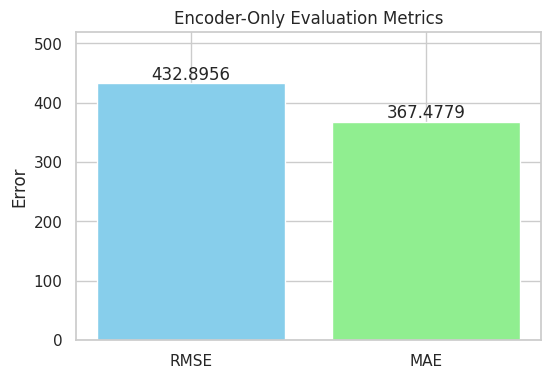

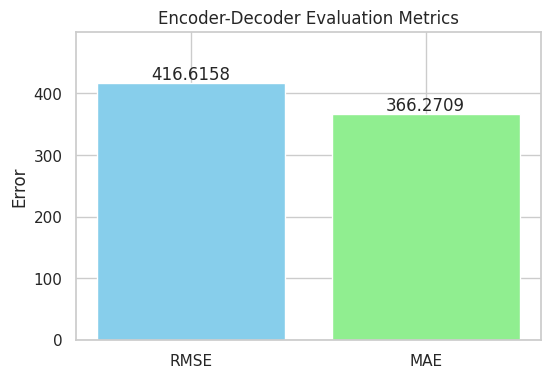

In [91]:
# Plot metrics
plot_metrics(
    rmse_enc_only,
    mae_enc_only,
    title='Encoder-Only Evaluation Metrics'
)

plot_metrics(
    rmse_enc_dec,
    mae_enc_dec,
    title='Encoder-Decoder Evaluation Metrics'
)

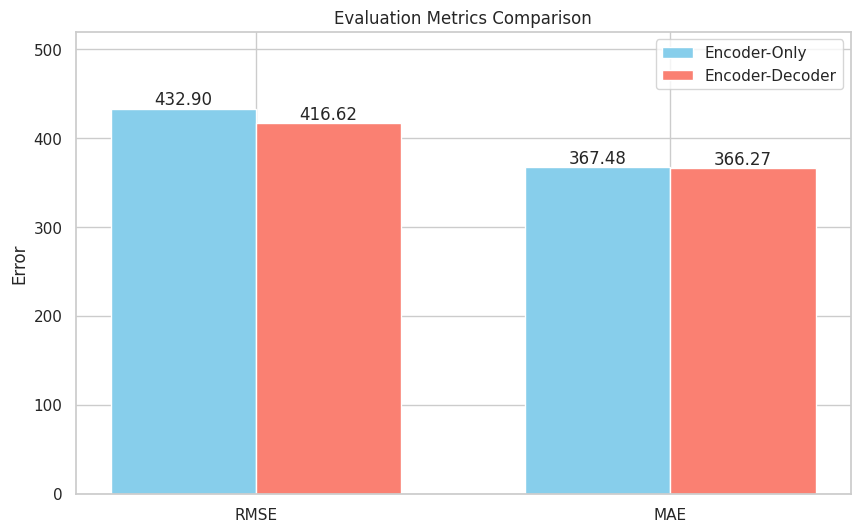

In [92]:
# Plot metrics for both models
def plot_metrics_comparison(metrics_df):
    """
    Plots RMSE, MAE, and MAPE for both models in a grouped bar chart.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing metrics for both models.
    """
    metrics = metrics_df['Metric'].tolist()
    encoder_only = metrics_df['Encoder-Only'].tolist()
    encoder_decoder = metrics_df['Encoder-Decoder'].tolist()

    x = np.arange(len(metrics))  # label locations
    width = 0.35  # bar width

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, encoder_only, width, label='Encoder-Only', color='skyblue')
    plt.bar(x + width/2, encoder_decoder, width, label='Encoder-Decoder', color='salmon')

    # Add labels, title, and custom x-axis tick labels
    plt.ylabel('Error')
    plt.title('Evaluation Metrics Comparison')
    plt.xticks(x, metrics)
    plt.legend()

    # Add value labels on top of the bars
    for i in range(len(metrics)):
        plt.text(x[i] - width/2, encoder_only[i], f"{encoder_only[i]:.2f}", ha='center', va='bottom')
        plt.text(x[i] + width/2, encoder_decoder[i], f"{encoder_decoder[i]:.2f}", ha='center', va='bottom')

    plt.ylim(0, max(max(encoder_only), max(encoder_decoder)) * 1.2)
    plt.show()

plot_metrics_comparison(metrics_combined)

In [93]:
def plot_actual_vs_predicted(dates, actual, predicted, title='Actual vs Predicted Close Prices'):
    """
    Plots actual versus predicted 'Close' prices.

    Args:
        dates (pd.DatetimeIndex or list-like): Dates corresponding to the actual and predicted values.
        actual (np.ndarray): Actual 'Close' prices.
        predicted (np.ndarray): Predicted 'Close' prices.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Close', color='blue', linestyle='-')
    plt.plot(dates, predicted, label='Predicted Close', color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [94]:
# Adjust the slicing of prediction dates to match the number of predictions
prediction_dates = test_data.index[window_length:window_length + len(close_predictions_enc_only)]

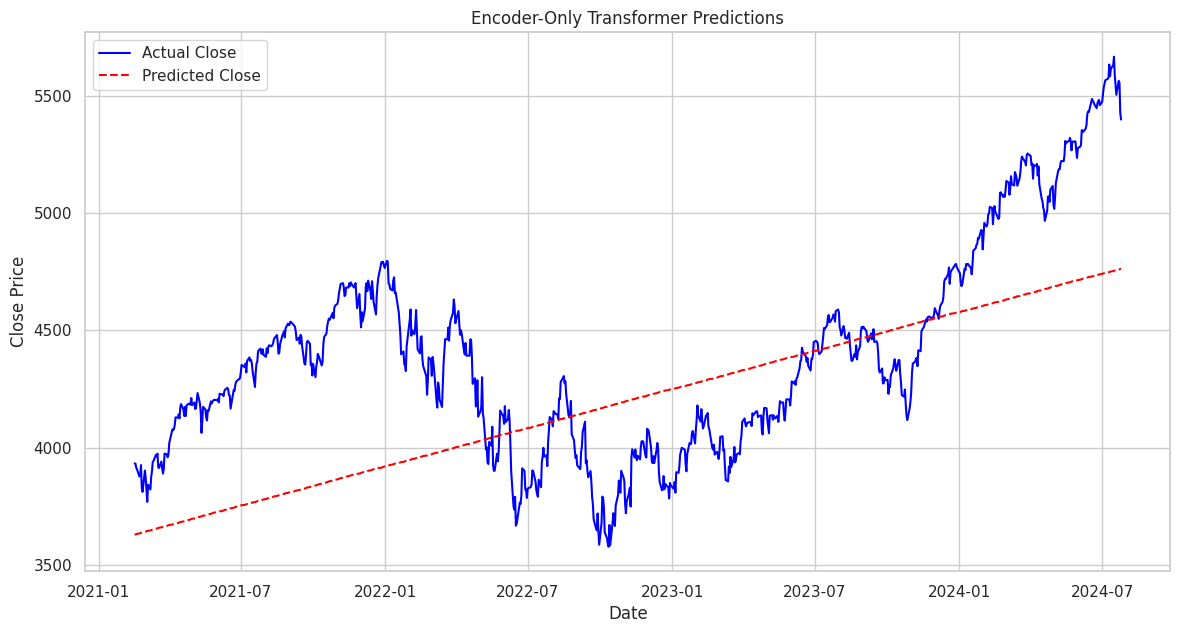

In [95]:
# Plot actual vs. predicted for Encoder-Only Transformer
plot_actual_vs_predicted(
    prediction_dates,
    actual_close_enc_only,
    close_predictions_enc_only,
    title='Encoder-Only Transformer Predictions'
)

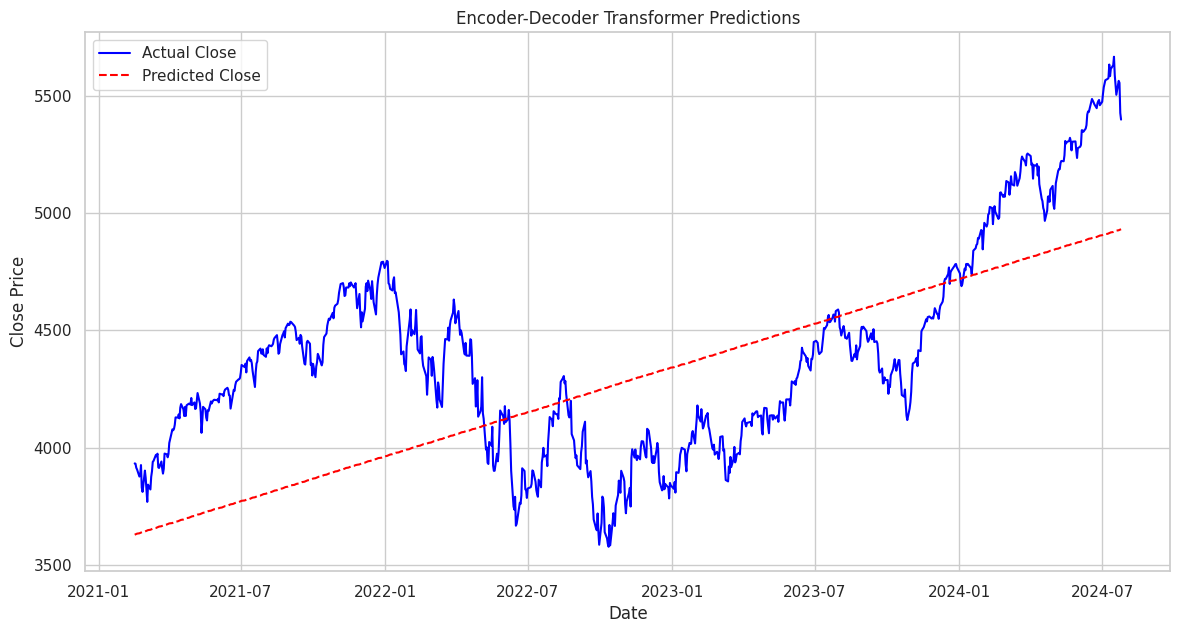

In [96]:
# Plot actual vs. predicted for Encoder-Decoder Transformer
plot_actual_vs_predicted(
    prediction_dates,
    actual_close_enc_dec,
    close_predictions_enc_dec,
    title='Encoder-Decoder Transformer Predictions'
)

In [97]:
def plot_comparison_actual_predicted(dates, actual, pred_enc_only, pred_enc_dec, title='Actual vs Predicted Close Prices'):
    """
    Plots actual versus predicted 'Close' prices for both Encoder-Only and Encoder-Decoder Transformer models on the same plot.

    Args:
        dates (pd.DatetimeIndex or list-like): Dates corresponding to the actual and predicted values.
        actual (np.ndarray): Actual 'Close' prices.
        pred_enc_only (np.ndarray): Predicted 'Close' prices from Encoder-Only Transformer.
        pred_enc_dec (np.ndarray): Predicted 'Close' prices from Encoder-Decoder Transformer.
        title (str, optional): Title of the plot. Defaults to 'Actual vs Predicted Close Prices'.

    Raises:
        AssertionError: If the lengths of the input arrays do not match.
    """
    # Ensure all input arrays have the same length
    assert len(dates) == len(actual) == len(pred_enc_only) == len(pred_enc_dec), \
        "All input arrays must have the same length."

    plt.figure(figsize=(14, 7))

    # Plot Actual Close Prices
    plt.plot(dates, actual, label='Actual Close', color='blue', linestyle='-')

    # Plot Predictions from Encoder-Only Transformer
    plt.plot(dates, pred_enc_only, label='Predicted Close (Encoder-Only)', color='red', linestyle='--')

    # Plot Predictions from Encoder-Decoder Transformer
    plt.plot(dates, pred_enc_dec, label='Predicted Close (Encoder-Decoder)', color='green', linestyle='-.')

    # Adding labels and title
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(title)

    # Adding legend
    plt.legend()

    # Adding grid for better readability
    plt.grid(True)

    # Display the plot
    plt.show()

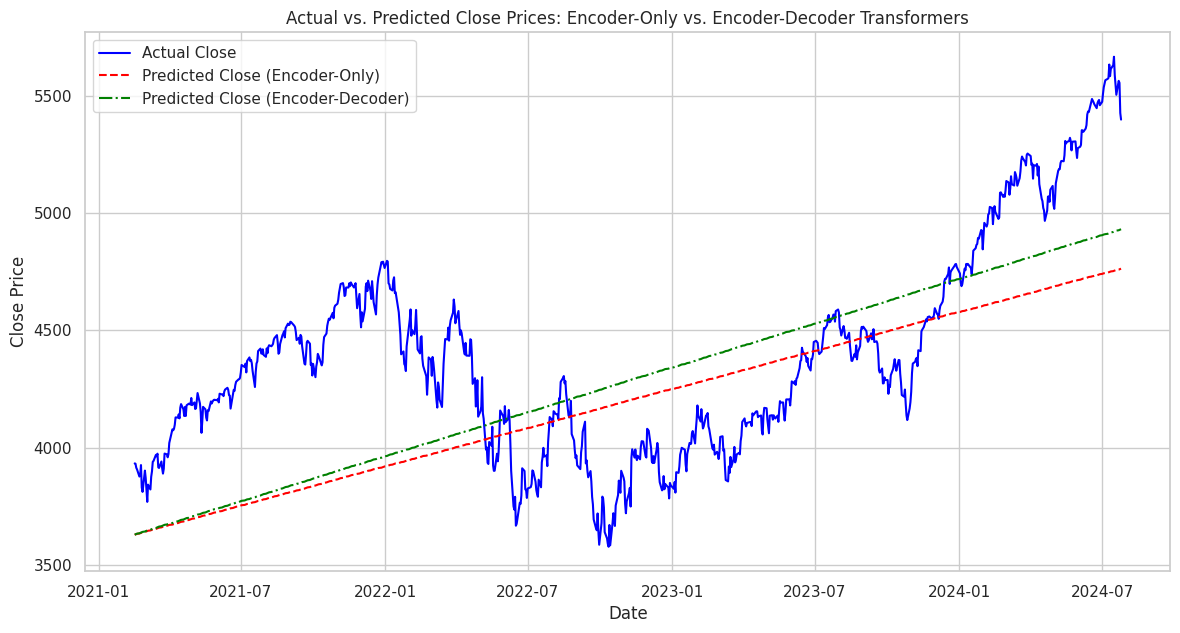

In [98]:
# Plot actual vs. predicted for both models
plot_comparison_actual_predicted(
    dates=prediction_dates,
    actual=actual_close_enc_only,
    pred_enc_only=close_predictions_enc_only,
    pred_enc_dec=close_predictions_enc_dec,
    title='Actual vs. Predicted Close Prices: Encoder-Only vs. Encoder-Decoder Transformers'
)